## **DESCRIPCION GENERAL:**
* El objetivo de esta notebook es servir de Analisis Exploratorio previo en el marco del challenge de MercadoLibre en el cual se busca predecir si un producto es nuevo o usado.
* Se busca entender con que datos se cuenta y asegurar previamente su calidad.
* Se busca detectar variables importantes con buen poder predictivo, asi como generar nuevas. 

In [356]:
#Se importan dependencias
import sys
from pathlib import Path

ROOT_DIR = Path("..").resolve()
sys.path.append(str(ROOT_DIR))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pandas.api.types import is_scalar
import re
import unicodedata
import ast

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans


# Reproducibilidad
np.random.seed(42)

# Estilo de display
pd.set_option('display.max_columns', 130)
pd.set_option('display.max_rows', 50)


### **Lectura:** 
Se leen los archivos ya aplanados y guardados en parquet con el archivo build_dataset.py

In [258]:
#carga de archivos
DATA_DIR = ROOT_DIR / "data" / "processed"

df_train = pd.read_parquet(DATA_DIR / "train_base.parquet")
df_test = pd.read_parquet(DATA_DIR / "test_base.parquet")

df_train.shape, df_test.shape


((90000, 56), (10000, 55))

In [363]:
df_train.columns

Index(['seller_address_country_name', 'seller_address_country_id',
       'seller_address_state_name', 'seller_address_state_id',
       'seller_address_city_name', 'seller_address_city_id', 'warranty',
       'sub_status', 'condition', 'deal_ids', 'base_price',
       'shipping_local_pick_up', 'shipping_methods', 'shipping_tags',
       'shipping_free_shipping', 'shipping_mode', 'shipping_dimensions',
       'non_mercado_pago_payment_methods', 'seller_id', 'variations',
       'site_id', 'listing_type_id', 'price', 'attributes', 'buying_mode',
       'tags', 'listing_source', 'parent_item_id', 'coverage_areas',
       'category_id', 'descriptions', 'last_updated',
       'international_delivery_mode', 'pictures', 'id', 'official_store_id',
       'differential_pricing', 'accepts_mercadopago', 'original_price',
       'currency_id', 'thumbnail', 'title', 'automatic_relist', 'date_created',
       'secure_thumbnail', 'stop_time', 'status', 'video_id',
       'catalog_product_id', 'subti

In [364]:
df_test.columns

Index(['seller_address_country_name', 'seller_address_country_id',
       'seller_address_state_name', 'seller_address_state_id',
       'seller_address_city_name', 'seller_address_city_id', 'warranty',
       'sub_status', 'deal_ids', 'base_price', 'shipping_local_pick_up',
       'shipping_methods', 'shipping_tags', 'shipping_free_shipping',
       'shipping_mode', 'shipping_dimensions',
       'non_mercado_pago_payment_methods', 'seller_id', 'variations',
       'site_id', 'listing_type_id', 'price', 'attributes', 'buying_mode',
       'tags', 'listing_source', 'parent_item_id', 'coverage_areas',
       'category_id', 'descriptions', 'last_updated',
       'international_delivery_mode', 'pictures', 'id', 'official_store_id',
       'differential_pricing', 'accepts_mercadopago', 'original_price',
       'currency_id', 'thumbnail', 'title', 'automatic_relist', 'date_created',
       'secure_thumbnail', 'stop_time', 'status', 'video_id',
       'catalog_product_id', 'subtitle', 'initia

### **1. Estructura General y limpieza inicial:** 
* Observo que columnas tengo, de que tipo son, si tienen muchos valores nulos, y si tienen poca/nula varianza.
* Objetivo: prescindir de columnas con todo/casi todo nulo o nada de varianza.

In [259]:
df_train.head(4)


,seller_address_country_name,seller_address_country_id,seller_address_state_name,seller_address_state_id,seller_address_city_name,seller_address_city_id,warranty,sub_status,condition,deal_ids,base_price,shipping_local_pick_up,shipping_methods,shipping_tags,shipping_free_shipping,shipping_mode,shipping_dimensions,non_mercado_pago_payment_methods,seller_id,variations,site_id,listing_type_id,price,attributes,buying_mode,tags,listing_source,parent_item_id,coverage_areas,category_id,descriptions,last_updated,international_delivery_mode,pictures,id,official_store_id,differential_pricing,accepts_mercadopago,original_price,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,stop_time,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity,shipping_free_methods
0,Argentina,AR,Capital Federal,AR-C,San Cristóbal,TUxBQlNBTjkwNTZa,None,[],new,[],80.00,True,[],[],False,not_specified,None,"[{'description': 'Transferencia bancaria', 'id...",8208882349,[],MLA,bronze,80.00,[],buy_it_now,[dragged_bids_and_visits],,MLA6553902747,[],MLA126406,[{'id': 'MLA4695330653-912855983'}],2015-09-05T20:42:58.000Z,none,"[{'id': '5386-MLA4695330653_052013', 'max_size...",MLA4695330653,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,Auriculares Samsung Originales Manos Libres Ca...,False,2015-09-05T20:42:53.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1446669773000,active,None,NaN,None,1,1441485773000,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1,None
1,Argentina,AR,Capital Federal,AR-C,Buenos Aires,,NUESTRA REPUTACION,[],used,[],"2,650.00",True,[],[],False,me2,None,"[{'description': 'Transferencia bancaria', 'id...",8141699488,[],MLA,silver,"2,650.00",[],buy_it_now,[],,MLA7727150374,[],MLA10267,[{'id': 'MLA7160447179-930764806'}],2015-09-26T18:08:34.000Z,none,"[{'id': '23223-MLA7160447179_022015', 'max_siz...",MLA7160447179,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/23223-MLA71604471...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,2015-09-26T18:08:30.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1448474910000,active,None,NaN,None,1,1443290910000,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1,None
2,Argentina,AR,Capital Federal,AR-C,Boedo,TUxBQkJPRTQ0OTRa,None,[],used,[],60.00,True,[],[],False,me2,None,"[{'description': 'Transferencia bancaria', 'id...",8386096505,[],MLA,bronze,60.00,[],buy_it_now,[dragged_bids_and_visits],,MLA6561247998,[],MLA1227,[{'id': 'MLA7367189936-916478256'}],2015-09-09T23:57:10.000Z,none,"[{'id': '22076-MLA7367189936_012015', 'max_siz...",MLA7367189936,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/22076-MLA73671899...,"Antigua Revista Billiken, N° 1826, Año 1954",False,2015-09-09T23:57:07.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1447027027000,active,None,NaN,None,1,1441843027000,http://articulo.mercadolibre.com.ar/MLA7367189...,0,1,None
3,Argentina,AR,Capital Federal,AR-C,Floresta,TUxBQkZMTzg5MjFa,None,[],new,[],580.00,True,[],[],False,me2,None,"[{'description': 'Transferencia bancaria', 'id...",5377752182,[],MLA,silver,580.00,[],buy_it_now,[],,None,[],MLA86345,[{'id': 'MLA9191625553-932309698'}],2015-10-05T16:03:50.306Z,none,"[{'id': '183901-MLA9191625553_092015', 'max_si...",MLA9191625553,NaN,None,True,NaN,ARS,http://mla-s2-p.mlstatic.com/183901-MLA9191625...,Alarma Guardtex Gx412 Seguridad Para El Automo...,False,2015-09-28T18:47:56.000Z,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,1449191596000,active,None,NaN,None,1,1443466076000,http://articulo.mercadolibre.com.ar/MLA9191625...,0,1,None


In [260]:
df_test.head(4)

,seller_address_country_name,seller_address_country_id,seller_address_state_name,seller_address_state_id,seller_address_city_name,seller_address_city_id,warranty,sub_status,deal_ids,base_price,shipping_local_pick_up,shipping_methods,shipping_tags,shipping_free_shipping,shipping_mode,shipping_dimensions,non_mercado_pago_payment_methods,seller_id,variations,site_id,listing_type_id,price,attributes,buying_mode,tags,listing_source,parent_item_id,coverage_areas,category_id,descriptions,last_updated,international_delivery_mode,pictures,id,official_store_id,differential_pricing,accepts_mercadopago,original_price,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,stop_time,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity,shipping_free_methods
0,Argentina,AR,Buenos Aires,AR-B,General Rodríguez,TUxBQ0dFTjY4NTg,None,[],[],"6,700.00",True,[],[],False,custom,None,"[{'description': 'Transferencia bancaria', 'id...",6469674142,[],MLA,silver,"6,700.00",[],buy_it_now,[dragged_bids_and_visits],,MLA2392767270,[],MLA1902,[{'id': 'MLA9379759063-915417858'}],2015-09-08T21:17:58.000Z,none,"[{'id': '884001-MLA9379759063_032015', 'max_si...",MLA9379759063,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/884001-MLA9379759...,Escritorio Secretter Espectacular,False,2015-09-08T21:17:57.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1446931077000,active,None,NaN,None,1,1441747077000,http://articulo.mercadolibre.com.ar/MLA9379759...,0,1,None
1,Argentina,AR,Capital Federal,AR-C,MICROCENTRO,,Sí,[],[],119.00,False,[],[],False,not_specified,None,[],5921388606,[],MLA,bronze,119.00,[],buy_it_now,[dragged_bids_and_visits],,MLA9748425635,[],MLA3530,[{'id': 'MLA8701321701-906672998'}],2015-08-29T12:55:05.000Z,none,"[{'id': '17326-MLA8701321701_072014', 'max_siz...",MLA8701321701,NaN,None,True,NaN,ARS,http://mla-s2-p.mlstatic.com/17326-MLA87013217...,Stassen Espatulas Milenio Numero 3 Codigo 590-3,False,2015-08-29T12:55:03.000Z,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,1446036902000,active,None,NaN,None,19,1440852902000,http://articulo.mercadolibre.com.ar/MLA8701321...,0,19,None
2,Argentina,AR,Buenos Aires,AR-B,Morón,TUxBQ01PUmI1NTBj,Sí,[],[],450.00,False,[],[],False,me2,None,[],5675694703,[],MLA,bronze,450.00,[],buy_it_now,[dragged_bids_and_visits],,MLA6473720967,[],MLA6440,[{'id': 'MLA7219741922-927838921'}],2015-09-23T12:41:09.000Z,none,"[{'id': '360601-MLA7219741922_072015', 'max_si...",MLA7219741922,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/360601-MLA7219741...,Charm Britania Plata 925 Ovalado!!! Armá La Tu...,False,2015-09-23T12:41:07.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1448196067000,active,None,NaN,None,2,1443012067000,http://articulo.mercadolibre.com.ar/MLA7219741...,0,2,None
3,Argentina,AR,Buenos Aires,AR-B,acassuso,,Sí,[],[],40.00,True,[],[],False,me2,None,"[{'description': 'Transferencia bancaria', 'id...",8566233865,[],MLA,bronze,40.00,[],buy_it_now,[dragged_bids_and_visits],,MLA8815658620,[],MLA2044,[{'id': 'MLA6450021454-896107706'}],2015-09-02T13:39:17.000Z,none,"[{'id': '387301-MLA6450021454_062015', 'max_si...",MLA6450021454,NaN,None,True,NaN,ARS,http://mla-s2-p.mlstatic.com/387301-MLA6450021...,El Hombre De Magallanes Virginia Carreño Novela,False,2015-08-16T13:34:01.000Z,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,1444916040000,active,None,NaN,None,1,1439732040000,http://articulo.mercadolibre.com.ar/MLA6450021...,0,1,None


In [261]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
df_train.info(verbose=True, max_cols=df_train.shape[1], memory_usage="deep", show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   seller_address_country_name       90000 non-null  object 
 1   seller_address_country_id         90000 non-null  object 
 2   seller_address_state_name         90000 non-null  object 
 3   seller_address_state_id           90000 non-null  object 
 4   seller_address_city_name          90000 non-null  object 
 5   seller_address_city_id            90000 non-null  object 
 6   warranty                          35243 non-null  object 
 7   sub_status                        90000 non-null  object 
 8   condition                         90000 non-null  object 
 9   deal_ids                          90000 non-null  object 
 10  base_price                        90000 non-null  float64
 11  shipping_local_pick_up            90000 non-null  bool   
 12  ship

#### **Estandarizar Nulos:**
Me di cuenta que hay columnas que tienen valor vacio pero no figuran como null

In [262]:
NULL_TOKENS = {'', ' ', 'na', 'n/a', 'none', 'null', 'nan', '[]', '{}'}

def normalize_cat_nulls(series: pd.Series) -> pd.Series:
    """
    Normaliza representaciones de nulos en variables categóricas:
    '', 'na', 'null', listas/dicts/arrays vacíos → pd.NA
    Todo lo no escalar se convierte a string.
    """

    def _to_na(x):
        # ---------------- arrays ----------------
        if isinstance(x, np.ndarray):
            if x.size == 0:
                return pd.NA
            return str(x)

        # ---------------- listas / dicts / sets ----------------
        if isinstance(x, (list, tuple, set, dict)):
            if len(x) == 0:
                return pd.NA
            return str(x)

        # ---------------- None / NaN ----------------
        if x is None:
            return pd.NA
        if isinstance(x, float) and math.isnan(x):
            return pd.NA
        if pd.isna(x):
            return pd.NA

        # ---------------- escalares ----------------
        x_str = str(x).strip().lower()
        if x_str in NULL_TOKENS:
            return pd.NA

        return x

    return series.map(_to_na)

In [361]:
df_train.select_dtypes(include=["category","object"]).drop(columns=['condition']).columns

Index(['seller_address_country_name', 'seller_address_country_id',
       'seller_address_state_name', 'seller_address_state_id',
       'seller_address_city_name', 'seller_address_city_id', 'warranty',
       'sub_status', 'deal_ids', 'shipping_methods', 'shipping_tags',
       'shipping_mode', 'shipping_dimensions',
       'non_mercado_pago_payment_methods', 'variations', 'site_id',
       'listing_type_id', 'attributes', 'buying_mode', 'tags',
       'listing_source', 'parent_item_id', 'coverage_areas', 'category_id',
       'descriptions', 'last_updated', 'international_delivery_mode',
       'pictures', 'id', 'differential_pricing', 'currency_id', 'thumbnail',
       'title', 'date_created', 'secure_thumbnail', 'status', 'video_id',
       'subtitle', 'permalink', 'shipping_free_methods'],
      dtype='object')

In [263]:
cat_cols = df_train.select_dtypes(include=["category","object"]).drop(columns=['condition']).columns

for col in cat_cols:
    df_train[col] = normalize_cat_nulls(df_train[col])
    df_test[col] = normalize_cat_nulls(df_test[col])

In [264]:
#Distribucion del target
df_train["condition"].value_counts()
df_train["condition"].value_counts(normalize=True)

#Target balanceado

condition
new    0.54
used   0.46
Name: proportion, dtype: float64

In [265]:
#Faltantes
missing_ratio = (
    df_train.isnull()
    .mean()
    .sort_values(ascending=False)
)

missing_ratio.head(20)


shipping_methods                   1.00
differential_pricing               1.00
coverage_areas                     1.00
subtitle                           1.00
international_delivery_mode        1.00
listing_source                     1.00
catalog_product_id                 1.00
shipping_dimensions                1.00
shipping_tags                      1.00
original_price                     1.00
deal_ids                           1.00
official_store_id                  0.99
sub_status                         0.99
video_id                           0.97
shipping_free_methods              0.97
variations                         0.92
attributes                         0.88
warranty                           0.61
seller_address_city_id             0.55
non_mercado_pago_payment_methods   0.31
dtype: float64

**Insight-provocacion resultante:** 
* Las que tienen mas de 80% de null eliminar (subtitle; differential_pricing; catalog_prodct_id; shipping_dimensions;
original_price; official_store_id; video_id; shipping_free_methods); 
* Warranty si bien tiene 60% de null a prioori parece tener buena relacion con el target. La voy a dejar y luego voy a medir su feature importance

In [266]:
#Funcion para chequear si un valor es escalar
def _to_hashable(v):
    # 1. estructuras complejas → string directo
    if isinstance(v, (list, dict, np.ndarray)):
        return str(v)

    # 2. None
    if v is None:
        return pd.NA

    # 3. NaN float
    if isinstance(v, float) and math.isnan(v):
        return pd.NA

    # 4. pandas NA
    try:
        if pd.isna(v):
            return pd.NA
    except Exception:
        pass

    # 5. no escalar → string
    if not is_scalar(v):
        return str(v)

    return v


#Función para detectar columnas con varianza nula o casi nula
def detect_low_variance_columns(
    df: pd.DataFrame,
    freq_threshold: float = 0.99,
    min_unique: int = 2
):
    records = []

    for col in df.columns:
        s = df[col].map(_to_hashable)

        # completamente nula
        if s.notna().sum() == 0:
            records.append({
                "column": col,
                "type": "all_null",
                "n_unique": 0,
                "top_freq": 1.0
            })
            continue

        n_unique = s.nunique(dropna=True)

        vc = s.value_counts(dropna=True, normalize=True)
        top_freq = vc.iloc[0]

        if n_unique < min_unique:
            records.append({
                "column": col,
                "type": "zero_variance",
                "n_unique": n_unique,
                "top_freq": top_freq
            })
        elif top_freq >= freq_threshold:
            records.append({
                "column": col,
                "type": "near_zero_variance",
                "n_unique": n_unique,
                "top_freq": top_freq
            })

    return (
        pd.DataFrame(records)
        .sort_values(["type", "top_freq"], ascending=[True, False])
        .reset_index(drop=True)
    )


In [267]:
low_var_cols = detect_low_variance_columns(df_train, freq_threshold=0.98)

low_var_cols.head(20)

,column,type,n_unique,top_freq
0,shipping_methods,all_null,0,1.00
1,listing_source,all_null,0,1.00
2,coverage_areas,all_null,0,1.00
3,international_delivery_mode,all_null,0,1.00
4,differential_pricing,all_null,0,1.00
5,subtitle,all_null,0,1.00
6,currency_id,near_zero_variance,2,0.99
7,shipping_free_methods,near_zero_variance,5,0.98
8,seller_address_country_name,zero_variance,1,1.00
9,seller_address_country_id,zero_variance,1,1.00


**Insight:** Hay varias columnas con varianza nula o casi nula que podrían ser eliminadas para simplificar el modelo haciendo más eficiente el entrenamiento
y sin perder performance predictiva, ya que son columnas que al no tener prácticamente variabilidad no aportan información relevante para la predicción.

**Quitar columnas con poco valor:** A continuacion se eliminan las columnas con casi nada de varianza o casi todos valores nulos para reducir ruido y seguir con el EDA.

In [268]:
def drop_low_variance_columns(
    df: pd.DataFrame,
    low_var_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Elimina columnas detectadas como zero_variance, near_zero_variance o all_null
    """
    cols_to_drop = low_var_df["column"].tolist()

    return df.drop(columns=cols_to_drop, errors="ignore")


low_var_cols = detect_low_variance_columns(df_train)
df_train_clean = drop_low_variance_columns(df_train, low_var_cols)
df_test_clean = drop_low_variance_columns(df_test, low_var_cols)


In [ ]:
def drop_high_null_columns(
    df: pd.DataFrame,
    null_threshold: float = 0.8
):
    """
    Elimina columnas con proporción de nulos mayor al threshold
    """
    null_ratio = df.isna().mean()

    cols_to_drop = null_ratio[null_ratio >= null_threshold].index.tolist()

    return df.drop(columns=cols_to_drop), cols_to_drop


# ESTO VA A SER MUY IMPORTANTE EN EL FEATURE ENGINEERING: Calcular SOLO en train
df_train_clean, high_null_cols = drop_high_null_columns(
    df_train_clean,
    null_threshold=0.9
)

# Aplicar mismas columnas a test
df_test_clean = df_test_clean.drop(columns=high_null_cols, errors="ignore")


**Busqueda de variables redundantes:** 
A continuacion se busca detectar si existen columnas numericas que son redudnates entre si, es decir si aportan la misma informacion al modelo.

In [270]:
#Primero seleccionar columnas numericas y ovservar cuales son, y si tiene sentido que sean numericas o estan por error con ese formato
num_cols = df_train_clean.select_dtypes(include=["int64", "float64"]).columns
df_train_clean[num_cols].head(4)

,base_price,seller_id,price,stop_time,initial_quantity,start_time,sold_quantity,available_quantity
0,80.00,8208882349,80.00,1446669773000,1,1441485773000,0,1
1,"2,650.00",8141699488,"2,650.00",1448474910000,1,1443290910000,0,1
2,60.00,8386096505,60.00,1447027027000,1,1441843027000,0,1
3,580.00,5377752182,580.00,1449191596000,1,1443466076000,0,1


**Observacion:** 
* seller_id debe ser convertida a categorica;
* stop_time y start_time parecen ser un timestamp mal catalogado como numerico: convertir 

In [271]:
def normalize_column_types(df: pd.DataFrame, ts_cols: list) -> pd.DataFrame:
    df = df.copy()

    # seller_id → categórica
    if "seller_id" in df.columns:
        df["seller_id"] = df["seller_id"].astype("category")

    # timestamps en ms → datetime
    for col in ts_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], unit="ms", errors="coerce")

    return df

df_train_clean = normalize_column_types(df_train_clean, ts_cols=["start_time", "stop_time"])
df_test_clean  = normalize_column_types(df_test_clean, ts_cols=["start_time", "stop_time"])

In [272]:
df_train_clean = df_train_clean.drop(columns=["last_updated", "date_created"])
df_test_clean = df_test_clean.drop(columns=["last_updated", "date_created"])

**Observacion:**
* Las columnas start_time y date_created son redundantes. Me quedo con start_time.
* La columna last_updated podria brindar algo de sñal en casos donde la publicacion haya sido actualizada, pero en una version inicial me quedare solo con start_time y trabajare a partir de ella.

In [273]:
import numpy as np
import pandas as pd


def remove_highly_correlated_features(
    df: pd.DataFrame,
    threshold: float = 0.99,
    random_state: int = 42,
    verbose: bool = True
):
    """
    Detecta features numéricas altamente correlacionadas (Spearman),
    elimina redundantes y deja trazabilidad de la decisión.
    """

    rng = np.random.default_rng(random_state)

    num_cols = df.select_dtypes(include="number").columns

    if len(num_cols) < 2:
        if verbose:
            print("⚠️ Not enough numerical columns for correlation analysis.")
        return df, pd.DataFrame()

    corr_matrix = df[num_cols].corr(method="spearman")

    records = []
    to_drop = set()
    cols = corr_matrix.columns

    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            corr = corr_matrix.iloc[i, j]

            if abs(corr) >= threshold:
                f1, f2 = cols[i], cols[j]

                if f1 in to_drop or f2 in to_drop:
                    continue

                nulls_f1 = df[f1].isna().mean()
                nulls_f2 = df[f2].isna().mean()

                if nulls_f1 > nulls_f2:
                    drop, keep = f1, f2
                    decision = "more_nulls"
                elif nulls_f2 > nulls_f1:
                    drop, keep = f2, f1
                    decision = "more_nulls"
                else:
                    drop = rng.choice([f1, f2])
                    keep = f2 if drop == f1 else f1
                    decision = "random_same_nulls"

                to_drop.add(drop)

                records.append({
                    "feature_1": f1,
                    "feature_2": f2,
                    "spearman_corr": corr,
                    "kept_feature": keep,
                    "dropped_feature": drop,
                    "decision_rule": decision,
                    "null_rate_f1": round(nulls_f1, 4),
                    "null_rate_f2": round(nulls_f2, 4)
                })

    summary_df = pd.DataFrame(records)

    if not summary_df.empty:
        summary_df = summary_df.sort_values(
            "spearman_corr",
            key=lambda s: s.abs(),
            ascending=False
        )

    if verbose:
        print(f"\n📊 High Correlation Summary (Spearman ≥ {threshold})")
        print("-" * 80)

        if summary_df.empty:
            print("✅ No highly correlated numerical features detected.")
        else:
            for _, row in summary_df.iterrows():
                print(
                    f"{row['feature_1']} <-> {row['feature_2']} | "
                    f"ρ={row['spearman_corr']:.3f} | "
                    f"DROP: {row['dropped_feature']} | "
                    f"KEEP: {row['kept_feature']} | "
                    f"RULE: {row['decision_rule']}"
                )

        print("\n🗑️ Columns dropped:", sorted(to_drop))
        print(f"📉 Total dropped: {len(to_drop)}")

    df_clean = df.drop(columns=list(to_drop))

    return df_clean, summary_df



In [274]:
    df_train_clean, corr_summary = remove_highly_correlated_features(
        df_train_clean,
        threshold=0.99,
        verbose=True
    )

    if (
        corr_summary is not None
        and not corr_summary.empty
        and "dropped_feature" in corr_summary.columns
    ):
        df_test_clean = df_test_clean.drop(
            columns=corr_summary["dropped_feature"].unique(),
            errors="ignore"
        )




📊 High Correlation Summary (Spearman ≥ 0.99)
--------------------------------------------------------------------------------
base_price <-> price | ρ=1.000 | DROP: base_price | KEEP: price | RULE: random_same_nulls
initial_quantity <-> available_quantity | ρ=0.991 | DROP: available_quantity | KEEP: initial_quantity | RULE: random_same_nulls

🗑️ Columns dropped: [np.str_('available_quantity'), np.str_('base_price')]
📉 Total dropped: 2


* No se detectan columnas con correlacion mayor o igual a 0.99.

### **2.Analisis de columnas restantes:**
* Primero voy a ver con cuales columnas me quedo y su tipo
* Luego entender si necesitan alguna transformacion
* Despues la idea es observar sus distribuciones y su vinculo con el target
* Finalmente entender si a partir de las columnas restantes es posible generar alguna nueva feature de valor

#### **Tipos de Columnas**

In [275]:
#Tipos de variables
df_train_clean.dtypes.value_counts()


object            22
bool               4
int64              2
datetime64[ns]     2
float64            1
category           1
Name: count, dtype: int64

In [276]:
info_df = pd.DataFrame({
    "dtype": df_train_clean.dtypes,
    "non_nulls": df_train_clean.notna().sum(),
    "nulls": df_train_clean.isna().sum(),
    "null_rate": df_train_clean.isna().mean()
}).sort_index()

info_df


,dtype,non_nulls,nulls,null_rate
accepts_mercadopago,bool,90000,0,0.00
attributes,object,11150,78850,0.88
automatic_relist,bool,90000,0,0.00
buying_mode,object,90000,0,0.00
category_id,object,90000,0,0.00
condition,object,90000,0,0.00
descriptions,object,87583,2417,0.03
id,object,90000,0,0.00
initial_quantity,int64,90000,0,0.00
listing_type_id,object,90000,0,0.00


### **2.1 Analisis detallado de columnas categoricas:**

In [277]:
df_train_clean.select_dtypes(include=["object","category"]).columns

Index(['seller_address_state_name', 'seller_address_state_id',
       'seller_address_city_name', 'seller_address_city_id', 'warranty',
       'condition', 'shipping_mode', 'non_mercado_pago_payment_methods',
       'seller_id', 'listing_type_id', 'attributes', 'buying_mode', 'tags',
       'parent_item_id', 'category_id', 'descriptions', 'pictures', 'id',
       'thumbnail', 'title', 'secure_thumbnail', 'status', 'permalink'],
      dtype='object')

In [278]:
#Funcion para resumen de variables categoricas
def categorical_summary(
    series: pd.Series,
    top_n: int = 10,
    dropna: bool = True
) -> dict:
    """
    Analiza una variable categórica y devuelve un resumen básico.

    Retorna un diccionario con:
    - n_nulls
    - pct_nulls
    - n_unique
    - top_values (DataFrame)
    """

    total = len(series)
    n_nulls = series.isna().sum()
    pct_nulls = round(n_nulls / total, 4)

    n_unique = series.nunique(dropna=dropna)

    top_values = (
        series
        .value_counts(dropna=dropna)
        .head(top_n)
        .rename("count")
        .reset_index()
        .rename(columns={"index": "category"})
    )

    top_values["proportion"] = (
        top_values["count"] / total
    ).round(4)

    return {
        "n_nulls": n_nulls,
        "pct_nulls": pct_nulls,
        "n_unique": n_unique,
        "top_values": top_values
    }


#### **2.1.1 Columnas de ubicacion**

In [279]:
# Cuenta de registros por provincia
df_state_counts = df_train_clean.groupby(
    ["seller_address_state_name","seller_address_state_id"]
).size().reset_index(name="count")

df_state_counts.sort_values("count", ascending=False)

,seller_address_state_name,seller_address_state_id,count
1,Capital Federal,AR-C,52143
0,Buenos Aires,AR-B,31482
20,Santa Fe,AR-S,2398
6,Córdoba,AR-X,1727
12,Mendoza,AR-M,400
4,Chubut,AR-U,335
7,Entre Ríos,AR-E,249
23,Tucumán,AR-T,214
17,San Juan,AR-J,132
16,Salta,AR-A,131


**Observacion:** Se puede ver que como es de esperar la mayoria de transacicones ocurren en CABA y Pcia de BsAs. Tambien se ve que cada provincia esta asociada a un codigo particular, con lo cual una de las 2 columnas puede ser eliminada. En el feature engineering me quedare con el codigo poqrque me parece mas limpio.

In [280]:
df_train_clean = df_train_clean.drop(columns=["seller_address_state_name"])
df_test_clean = df_test_clean.drop(columns=["seller_address_state_name"])

In [281]:
# Cuenta de registros por ciudad
df_city_counts = df_train_clean.groupby(
    ["seller_address_city_name","seller_address_city_id"]
).size().reset_index(name="count")

df_city_counts.sort_values("count", ascending=False).head(15)

,seller_address_city_name,seller_address_city_id,count
170,Palermo,TUxBQlBBTDI1MTVa,2950
33,Caballito,TUxBQkNBQjM4MDda,2620
19,Belgrano,TUxBQkJFTDcyNTJa,2013
86,Flores,TUxBQkZMTzMwNzRa,1441
270,Villa Crespo,TUxBQlZJTDQyMjBa,1407
146,Mataderos,TUxBQk1BVDMwMDJa,1396
206,Rosario,TUxBQ1JPUzg1Yjg3,1389
6,Almagro,TUxBQkFMTTMwNTBa,1061
14,Balvanera,TUxBQkJBTDMxMDZa,1045
10,Avellaneda,TUxBQ0FWRTc5OTQ1,966


**Observacion:** 
* Se observa una altisima cardinalidad y que en muchos casos la ciudad no es consistente, hay muchos barrios de CABA puestos como ciudad, y escritos de manera diferente
* tengo casi la mitad de valores nulos en la columna del id, con lo cual no es demasiado confiable para un analisis rapido
* Ya que tengo la provincia y por motivos de tiempo voy a prescindir de estas 2 columnas ya que su procesamiento resultaria muy engorroso

In [282]:
df_train_clean = df_train_clean.drop(columns=["seller_address_city_name","seller_address_city_id"])
df_test_clean = df_test_clean.drop(columns=["seller_address_city_name","seller_address_city_id"])

#### **2.1.2 Warranty**

In [283]:
categorical_summary(df_train_clean["warranty"])

{'n_nulls': np.int64(54786),
 'pct_nulls': np.float64(0.6087),
 'n_unique': 9535,
 'top_values':         warranty  count  proportion
 0             Sí   5107        0.06
 1   Sin garantía   4907        0.05
 2             SI    545        0.01
 3        6 meses    489        0.01
 4        6 MESES    361        0.00
 5             Si    311        0.00
 6             si    291        0.00
 7  MI REPUTACION    192        0.00
 8        3 meses    190        0.00
 9        3 MESES    183        0.00}

**Observacion:** 
* El formato no esta homogeneo (hay SI, Sì, si por ejemplo)
* Hay aproximadamente 60% de nulos
* Hay alta caridnalidad pero con cateogorias muy poco frecuentes
* Algunas formas de expresar la garantia incluyen el plazo, otras no
* **Decision:** considerar nulos como sin garantia; normalizar formato; conservar tanto las categoricas que expresan plazo como las que no. La idea es tratarala como categòrica y ver mas adelante si alguna categoria tiene alguna relacion mas marcada con el target.

In [284]:
def clean_warranty_column(
    series: pd.Series,
    min_freq: int = 100,
    other_label: str = "other",
    null_label: str = "sin_garantia"
) -> pd.Series:
    """
    Limpia y normaliza una columna de warranty:
    1) Nulos -> sin_garantia
    2) Quita acentos y caracteres especiales
    3) lower + trim
    4) Homogeneiza expresiones semanticas
    5) Agrupa categorias poco frecuentes como 'other'
    """

    s = series.copy()

    # -------------------------------------------------
    # 1. Imputar nulos
    # -------------------------------------------------
    s = s.fillna(null_label)

    # -------------------------------------------------
    # 2. Normalizar texto base
    # -------------------------------------------------
    def normalize_text(x: str) -> str:
        x = unicodedata.normalize("NFKD", x)
        x = x.encode("ascii", "ignore").decode("utf-8")
        x = re.sub(r"[^a-zA-Z0-9\s]", " ", x)
        x = re.sub(r"\s+", " ", x).strip().lower()
        return x

    s = s.astype(str).map(normalize_text)

    # -------------------------------------------------
    # 3. Normalizacion semantica (ROBUSTA)
    # -------------------------------------------------
    s = s.replace(
        {
            # ---------- años -> meses ----------
            r".*\b(1|un)\s+ano\b.*": "12 meses",
            r".*\bano\s+de\s+garantia\b.*": "12 meses",

            # ---------- meses ----------
            r".*\b6\s+meses\b.*": "6 meses",
            r".*\b3\s+meses\b.*": "3 meses",

            # ---------- dias ----------
            r".*\b60\s+dias\b.*": "2 meses",

            # ---------- garantia explicita ----------
            r".*con\s+garantia.*": "si",
            r".*100\s+garantizados.*": "si",
            r".*garantia\s+total.*": "si",
            r".*se\s+garantiza\s+la\s+descripcion.*": "si",
            r".*defectos\s+de\s+fabricacion.*": "si",

            # ---------- fabricante ----------
            r".*de\s+fabrica.*": "si",
            r".*del\s+fabricante.*": "si",
            r".*garantia\s+de\s+fabrica.*": "si",

            # ---------- reputacional ----------
            r".*mi\s+reputacion.*": "garantia_reputacional",
            r".*mis\s+calificaciones.*": "garantia_reputacional",
            r".*revisa\s+nuestras\s+calificaciones.*": "garantia_reputacional",
            r".*oferta\s+con\s+confianza.*": "garantia_reputacional",

            # ---------- textos logisticos ----------
            r".*caja\s+sellada.*": other_label,
        },
        regex=True
    )

    # -------------------------------------------------
    # 4. Agrupar categorias poco frecuentes
    # -------------------------------------------------
    value_counts = s.value_counts()
    frequent_values = value_counts[value_counts >= min_freq].index

    s = s.where(s.isin(frequent_values), other_label)

    return s


In [285]:
df_train_clean["warranty_clean"] = clean_warranty_column(
    df_train_clean["warranty"],
    min_freq=100
)

df_test_clean["warranty_clean"] = clean_warranty_column(
    df_test_clean["warranty"],
    min_freq=100
)
df_train_clean["warranty_clean"].value_counts()

warranty_clean
sin garantia             59709
other                    12302
si                       10508
6 meses                   2570
garantia_reputacional     2163
12 meses                  1644
3 meses                    903
2 meses                    201
Name: count, dtype: int64

In [286]:
df_train_clean = df_train_clean.drop(columns=["warranty"])
df_test_clean = df_test_clean.drop(columns=["warranty"])

#### **2.1.3 shipping_mode**

In [287]:
categorical_summary(
    df_train_clean["shipping_mode"]
)

{'n_nulls': np.int64(0),
 'pct_nulls': np.float64(0.0),
 'n_unique': 4,
 'top_values':    shipping_mode  count  proportion
 0            me2  46059        0.51
 1  not_specified  40725        0.45
 2         custom   3130        0.03
 3            me1     86        0.00}

**Observacion:** Poca cardinalidad, sin nulos. Se conserva como esta.

#### **2.1.4 non_mercadopago_payment_mthods**

In [288]:
categorical_summary(
    df_train_clean["non_mercado_pago_payment_methods"]
)

{'n_nulls': np.int64(27531),
 'pct_nulls': np.float64(0.3059),
 'n_unique': 173,
 'top_values':                     non_mercado_pago_payment_methods  count  proportion
 0  [{'description': 'Transferencia bancaria', 'id...  20303        0.23
 1  [{'description': 'Transferencia bancaria', 'id...  18678        0.21
 2  [{'description': 'Efectivo', 'id': 'MLAMO', 't...  12915        0.14
 3  [{'description': 'Transferencia bancaria', 'id...   2328        0.03
 4  [{'description': 'Transferencia bancaria', 'id...   1613        0.02
 5  [{'description': 'Tarjeta de crédito', 'id': '...   1173        0.01
 6  [{'description': 'Acordar con el comprador', '...    937        0.01
 7  [{'description': 'Acordar con el comprador', '...    768        0.01
 8  [{'description': 'Transferencia bancaria', 'id...    569        0.01
 9  [{'description': 'Transferencia bancaria', 'id...    521        0.01}

**Observacion:** 
* La informacion esta encapsulada en diccionarios, es imposible de trabajar como esta.
* Presenta mucha cardinalidad.
* Se genera una columna que busca resumir que otros medios de pago son aceptados.

In [289]:
ID_PATTERN = re.compile(r"'id'\s*:\s*'([^']+)'")

def extract_payment_ids(x):
    if x is None or pd.isna(x):
        return []

    if isinstance(x, str):
        return ID_PATTERN.findall(x)

    return []

def clean_non_mp_payment_methods(
    series: pd.Series,
    min_freq: int = 100,
    other_label: str = "other"
):
    # Aseguramos list[str]
    parsed = series.map(
        lambda x: list(x) if isinstance(x, (list, tuple)) else []
    )

    flags = pd.DataFrame({
        "accepts_cash": parsed.map(lambda x: "MLAMO" in x),
        "accepts_transfer": parsed.map(lambda x: "MLATB" in x),
        "accepts_card": parsed.map(
            lambda x: any(
                i.startswith("MLA") and i not in {"MLAMO", "MLATB", "MLAWC"}
                for i in x
            )
        ),
        "accepts_agreement": parsed.map(lambda x: "MLAWC" in x),
        "accepts_non_mp": parsed.map(lambda x: len(x) > 0),
    }).astype(int)

    def summarize(row):
        if row["accepts_non_mp"] == 0:
            return "solo_mp"

        keys = []
        if row["accepts_cash"]:
            keys.append("efectivo")
        if row["accepts_transfer"]:
            keys.append("transferencia")
        if row["accepts_card"]:
            keys.append("tarjeta")
        if row["accepts_agreement"]:
            keys.append("acordar")

        if len(keys) == 1:
            return keys[0]
        if len(keys) <= 3:
            return "_".join(sorted(keys))
        return "mixto"

    summary = flags.apply(summarize, axis=1)

    vc = summary.value_counts()
    frequent = vc[vc >= min_freq].index
    summary = summary.where(summary.isin(frequent), other_label)

    return summary


In [290]:
#Se parsea la columna para que solo conserve los ID
df_train_clean["non_mercado_pago_payment_methods"] = df_train_clean["non_mercado_pago_payment_methods"].map(extract_payment_ids)
df_test_clean["non_mercado_pago_payment_methods"] = df_test_clean["non_mercado_pago_payment_methods"].map(extract_payment_ids)

#Se genera la columna con mas sentido semantico
df_train_clean["non_mp_payment_clean"] = (
    clean_non_mp_payment_methods(
        df_train_clean["non_mercado_pago_payment_methods"],
        min_freq=100
    )
)

df_test_clean["non_mp_payment_clean"] = (
    clean_non_mp_payment_methods(
        df_test_clean["non_mercado_pago_payment_methods"],
        min_freq=100
    )
)

In [291]:
df_train_clean["non_mp_payment_clean"].value_counts()

non_mp_payment_clean
solo_mp                           27531
efectivo_transferencia            20303
efectivo_tarjeta_transferencia    19798
efectivo                          12915
mixto                              2880
acordar_efectivo_transferencia     2328
efectivo_tarjeta                   1202
acordar                             937
acordar_efectivo                    768
transferencia                       569
tarjeta_transferencia               334
tarjeta                             173
acordar_efectivo_tarjeta            156
other                               106
Name: count, dtype: int64

In [292]:
df_train_clean = df_train_clean.drop(columns=["non_mercado_pago_payment_methods"])
df_test_clean = df_test_clean.drop(columns=["non_mercado_pago_payment_methods"])

#### **2.1.5 seller_id**

In [293]:
categorical_summary(
    df_train_clean["seller_id"]
)

{'n_nulls': np.int64(0),
 'pct_nulls': np.float64(0.0),
 'n_unique': 33281,
 'top_values':     seller_id  count  proportion
 0  5248662274    850        0.01
 1  2015548469    654        0.01
 2  7704929703    424        0.00
 3  4631246902    408        0.00
 4  8612126795    318        0.00
 5  2266082781    302        0.00
 6  6972484560    259        0.00
 7  6846806944    251        0.00
 8  4248718919    244        0.00
 9  1387735603    240        0.00}

**Observacion:** 
* No hay valores faltantes
* Hay aproximadamente 30k de vendedores (aporx 3 publicaciones por vendedor en promedio)
* Usar el vendedor como feature puede ser un problema ya que pordira generar overfitting, y tendriamos el problema de que en test pueden aparecefr nuevos vendedores que no esten en train.
* **Prescindir de la columna**

In [294]:
df_train_clean = df_train_clean.drop(columns=["seller_id"])
df_test_clean = df_test_clean.drop(columns=["seller_id"])

#### **2.1.6 listing_type_id**

In [295]:
categorical_summary(
    df_train_clean["listing_type_id"]
)

{'n_nulls': np.int64(0),
 'pct_nulls': np.float64(0.0),
 'n_unique': 7,
 'top_values':   listing_type_id  count  proportion
 0          bronze  56904        0.63
 1            free  19260        0.21
 2          silver   8195        0.09
 3    gold_special   2693        0.03
 4            gold   2170        0.02
 5    gold_premium    765        0.01
 6        gold_pro     13        0.00}

**Observacion:**
* Hay 7 categorias, las cuales presentan un orden de importancia; un gold_pro es la mejor categoria, siendo free la peor. Es muy probable que las mejores categorias tengan mas chances de ser tiendas oficiales.
* Reemplazar por numeros del 1 al 7 para mantener la relacion de orden.

In [296]:
def encode_listing_type_ordinal(
    series: pd.Series,
    unknown_value: int = 0
) -> pd.Series:
    """
    Codifica listing_type_id como variable ordinal.
    
    Orden (peor -> mejor):
    free (1)
    bronze (2)
    silver (3)
    gold (4)
    gold_special (5)
    gold_premium (6)
    gold_pro (7)
    
    Valores no vistos -> unknown_value (default 0)
    """

    mapping = {
        "free": 1,
        "bronze": 2,
        "silver": 3,
        "gold": 4,
        "gold_special": 5,
        "gold_premium": 6,
        "gold_pro": 7,
    }

    return (
        series
        .astype(str)
        .str.lower()
        .map(mapping)
        .fillna(unknown_value)
        .astype(int)
    )


In [297]:
df_train_clean["listing_type_ord"] = encode_listing_type_ordinal(
    df_train_clean["listing_type_id"]
)

df_test_clean["listing_type_ord"] = encode_listing_type_ordinal(
    df_test_clean["listing_type_id"]
)
df_train_clean = df_train_clean.drop(columns=["listing_type_id"])
df_test_clean = df_test_clean.drop(columns=["listing_type_id"])

In [298]:
df_train_clean["listing_type_ord"].value_counts()

listing_type_ord
2    56904
1    19260
3     8195
5     2693
4     2170
6      765
7       13
Name: count, dtype: int64

#### **2.1.6 attributes**

In [299]:
categorical_summary(
    df_train_clean["attributes"]
)

{'n_nulls': np.int64(78850),
 'pct_nulls': np.float64(0.8761),
 'n_unique': 3117,
 'top_values':                                           attributes  count  proportion
 0  [{'attribute_group_id': 'DFLT', 'attribute_gro...   1039        0.01
 1  [{'attribute_group_id': 'DFLT', 'attribute_gro...    997        0.01
 2  [{'attribute_group_id': 'DFLT', 'attribute_gro...    921        0.01
 3  [{'attribute_group_id': 'DFLT', 'attribute_gro...    724        0.01
 4  [{'attribute_group_id': 'DFLT', 'attribute_gro...    515        0.01
 5  [{'attribute_group_id': 'DFLT', 'attribute_gro...    426        0.00
 6  [{'attribute_group_id': 'DFLT', 'attribute_gro...    391        0.00
 7  [{'attribute_group_id': 'DFLT', 'attribute_gro...    308        0.00
 8  [{'attribute_group_id': 'FIND', 'attribute_gro...    250        0.00
 9  [{'attribute_group_id': 'DFLT', 'attribute_gro...    247        0.00}

**Observacion:**
* 87% de nulos; no tiene sentido usar esta columna

In [300]:
df_train_clean = df_train_clean.drop(columns=["attributes"])
df_test_clean = df_test_clean.drop(columns=["attributes"])

#### **2.1.6 buying_mode**

In [301]:
categorical_summary(
    df_train_clean["buying_mode"]
)

{'n_nulls': np.int64(0),
 'pct_nulls': np.float64(0.0),
 'n_unique': 3,
 'top_values':   buying_mode  count  proportion
 0  buy_it_now  87311        0.97
 1  classified   1982        0.02
 2     auction    707        0.01}

**Observacion:**
* Presenta 3 categorias y sin nulos
* El 97% del dataset esta domiando por una sola clase con lo cual es poco probale que la variable tenga demasiado poder predictivo; pero se la deja como esta y luego que el modelo decida su importancia (piendo usar un XGBoost o LightGBM)

#### **2.1.7 tags**

In [302]:
categorical_summary(
    df_train_clean["tags"]
)

{'n_nulls': np.int64(22412),
 'pct_nulls': np.float64(0.249),
 'n_unique': 7,
 'top_values':                                                 tags  count  proportion
 0                        ['dragged_bids_and_visits']  65315        0.73
 1  ['good_quality_thumbnail' 'dragged_bids_and_vi...   1191        0.01
 2                                 ['dragged_visits']    464        0.01
 3                         ['good_quality_thumbnail']    346        0.00
 4                   ['dragged_visits' 'free_relist']    259        0.00
 5  ['poor_quality_thumbnail' 'dragged_bids_and_vi...     10        0.00
 6                         ['poor_quality_thumbnail']      3        0.00}

**Observacion:** 
* Son tags de mercado libre para describir al vendedor
* Tal como esta la columna es imposible su uso
* Pienso que puede ser util extraer: un flag sobre si tiene un tag con la pabra 'good', otro para la palabra 'poor', yh una columna de conteo de tags 

In [303]:
def process_tags_features(series: pd.Series) -> pd.DataFrame:
    """
    Procesa una columna 'tags' y genera:
    - has_good_tag: flag si algún tag contiene 'good'
    - has_poor_tag: flag si algún tag contiene 'poor'
    - tags_count: cantidad total de tags
    """

    def parse_tags(x):
        if x is None or pd.isna(x):
            return []

        # Caso: lista real
        if isinstance(x, list):
            return x

        # Caso: string tipo "['a' 'b']"
        if isinstance(x, str):
            x = x.strip()

            if x in ("", "[]", "nan"):
                return []

            # extraer todo lo que esté entre comillas simples
            tags = re.findall(r"'([^']+)'", x)
            return tags

        return []

    parsed = series.map(parse_tags)

    tags_count = parsed.map(len)

    has_good_tag = parsed.map(
        lambda tags: any("good" in t.lower() for t in tags)
    ).astype(bool)

    has_poor_tag = parsed.map(
        lambda tags: any("poor" in t.lower() for t in tags)
    ).astype(bool)
    
    return pd.DataFrame({
        "has_good_tag": has_good_tag,
        "has_poor_tag": has_poor_tag,
        "tags_count": tags_count
    })


In [304]:
tags_features_train = process_tags_features(df_train_clean["tags"])
tags_features_test = process_tags_features(df_test_clean["tags"])

df_train_clean = pd.concat([df_train_clean, tags_features_train], axis=1)
df_test_clean = pd.concat([df_test_clean, tags_features_test], axis=1)

In [305]:
categorical_summary(
    df_train_clean["tags_count"]
)

{'n_nulls': np.int64(0),
 'pct_nulls': np.float64(0.0),
 'n_unique': 3,
 'top_values':    tags_count  count  proportion
 0           1  66128        0.73
 1           0  22412        0.25
 2           2   1460        0.02}

In [306]:
categorical_summary(
    df_train_clean["has_good_tag"]
)

{'n_nulls': np.int64(0),
 'pct_nulls': np.float64(0.0),
 'n_unique': 2,
 'top_values':    has_good_tag  count  proportion
 0         False  88463        0.98
 1          True   1537        0.02}

In [307]:
categorical_summary(
    df_train_clean["has_poor_tag"]
)

{'n_nulls': np.int64(0),
 'pct_nulls': np.float64(0.0),
 'n_unique': 2,
 'top_values':    has_poor_tag  count  proportion
 0         False  89987        1.00
 1          True     13        0.00}

In [308]:
df_train_clean = df_train_clean.drop(columns=["tags"])
df_test_clean = df_test_clean.drop(columns=["tags"])

#### **2.1.7 parent_item_id**

In [309]:
categorical_summary(
    df_train_clean["parent_item_id"]
)

{'n_nulls': np.int64(20690),
 'pct_nulls': np.float64(0.2299),
 'n_unique': 69310,
 'top_values':   parent_item_id  count  proportion
 0  MLA6553902747      1        0.00
 1  MLA7727150374      1        0.00
 2  MLA6561247998      1        0.00
 3  MLA3133256685      1        0.00
 4  MLA5588379672      1        0.00
 5  MLA8744215055      1        0.00
 6  MLA4442923846      1        0.00
 7  MLA3677718570      1        0.00
 8  MLA4007511794      1        0.00
 9  MLA5519897707      1        0.00}

**Observacion:**
* Todos los valores que no estan en nulo son unicos
* Cardinalidad monstruosa; solo generaria ruido
* Se prescinde de la columna

In [310]:
df_train_clean = df_train_clean.drop(columns=["parent_item_id"])
df_test_clean = df_test_clean.drop(columns=["parent_item_id"])

#### **2.1.8 category_id**

In [311]:
categorical_summary(
    df_train_clean["category_id"]
)

{'n_nulls': np.int64(0),
 'pct_nulls': np.float64(0.0),
 'n_unique': 10491,
 'top_values':   category_id  count  proportion
 0     MLA1227   4139        0.05
 1     MLA2044   1759        0.02
 2    MLA41287    829        0.01
 3     MLA3530    685        0.01
 4     MLA2038    601        0.01
 5    MLA15171    522        0.01
 6    MLA15328    446        0.01
 7     MLA1383    416        0.00
 8    MLA41269    399        0.00
 9    MLA15204    395        0.00}

**Observacion:**
* Muy alta cardinalidad
* La calse que mas pesa es solo un 5%
* A partir de la 7 ya pesan menos de 1% todas
* No se ve una semantica para agrupar
* Dado todo esto se prescinde de la columna

In [312]:
df_train_clean = df_train_clean.drop(columns=["category_id"])
df_test_clean = df_test_clean.drop(columns=["category_id"])

#### **2.1.8 descriptions**

In [313]:
categorical_summary(
    df_train_clean["descriptions"]
)

{'n_nulls': np.int64(2417),
 'pct_nulls': np.float64(0.0269),
 'n_unique': 87583,
 'top_values':                             descriptions  count  proportion
 0  ["{'id': 'MLA4695330653-912855983'}"]      1        0.00
 1  ["{'id': 'MLA7160447179-930764806'}"]      1        0.00
 2  ["{'id': 'MLA7367189936-916478256'}"]      1        0.00
 3  ["{'id': 'MLA9191625553-932309698'}"]      1        0.00
 4  ["{'id': 'MLA7787961817-902981678'}"]      1        0.00
 5  ["{'id': 'MLA6542680143-907239038'}"]      1        0.00
 6  ["{'id': 'MLA8224797916-939033580'}"]      1        0.00
 7  ["{'id': 'MLA1395917367-944499723'}"]      1        0.00
 8  ["{'id': 'MLA6054779321-934355208'}"]      1        0.00
 9  ["{'id': 'MLA3801903502-936622752'}"]      1        0.00}

**Observacion:**
* Altisima cardinalidad
* No obstante, puede llegar a servir generar un flag sobre si tiene o no descripcion

In [314]:
def add_has_description_flag(
    df: pd.DataFrame,
    desc_col: str = "descriptions",
    new_col: str = "has_description"
) -> pd.DataFrame:
    """
    Agrega un flag binario indicando si el item tiene descripción no vacía.
    
    Reglas:
    - NaN → 0
    - string vacío / solo espacios → 0
    - cualquier otro contenido → 1
    """

    df = df.copy()

    df[new_col] = (
        df[desc_col]
        .astype(str)
        .str.strip()
        .ne("")            # distinto de vacío
        .astype(bool)
    )

    # Si venía NaN originalmente, forzamos 0
    df.loc[df[desc_col].isna(), new_col] = 0

    return df


In [315]:
df_train_clean = add_has_description_flag(df_train_clean)
df_test_clean  = add_has_description_flag(df_test_clean)
df_train_clean["has_description"].value_counts()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_31008\100780608.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df[desc_col].isna(), new_col] = 0
C:\Users\Usuario\AppData\Local\Temp\ipykernel_31008\100780608.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df[desc_col].isna(), new_col] = 0


has_description
True    87583
0        2417
Name: count, dtype: int64

In [316]:
df_train_clean = df_train_clean.drop(columns=["descriptions"])
df_test_clean = df_test_clean.drop(columns=["descriptions"])

#### **2.1.8 id, thumbnail, secure_thumbnail y permalink**

In [317]:
categorical_summary(
    df_train_clean["id"]
)

{'n_nulls': np.int64(0),
 'pct_nulls': np.float64(0.0),
 'n_unique': 90000,
 'top_values':               id  count  proportion
 0  MLA4695330653      1        0.00
 1  MLA7160447179      1        0.00
 2  MLA7367189936      1        0.00
 3  MLA9191625553      1        0.00
 4  MLA7787961817      1        0.00
 5  MLA6542680143      1        0.00
 6  MLA8224797916      1        0.00
 7  MLA1395917367      1        0.00
 8  MLA6054779321      1        0.00
 9  MLA3801903502      1        0.00}

**Observacion:**
| Campo              | Mantener como feature | Motivo             |
| ------------------ | --------------------- | ------------------ |
| `id`               | No                  | Identificador puro |
| `thumbnail`        | No                  | URL sin señal      |
| `secure_thumbnail` | No                  | Redundante         |
| `permalink`        | No                  | URL + leakage      |

* Son identificadores unicos que no aportanl explicatividad y podrian inducir overfitting

In [318]:
df_train_clean = df_train_clean.drop(columns=["id", "thumbnail", "secure_thumbnail", "permalink"])
df_test_clean = df_test_clean.drop(columns=["id", "thumbnail", "secure_thumbnail", "permalink"])

#### **2.1.9 status**

In [319]:
categorical_summary(
    df_train_clean["status"]
)

{'n_nulls': np.int64(0),
 'pct_nulls': np.float64(0.0),
 'n_unique': 4,
 'top_values':            status  count  proportion
 0          active  86116        0.96
 1          paused   3863        0.04
 2          closed     20        0.00
 3  not_yet_active      1        0.00}

**Observacion:**
* Se mantiene como esta, como variable categorica
* Son 4 categorias, puede dar informacion relevante

#### **2.1.10 title**

In [244]:
categorical_summary(
    df_train_clean["title"]
)

{'n_nulls': np.int64(0),
 'pct_nulls': np.float64(0.0),
 'n_unique': 89008,
 'top_values':                                                title  count  proportion
 0      50 Suspensores Para Short De Baño Tela Calada     66        0.00
 1    50 Suspensores Para Short De Baño Nido De Abeja     45        0.00
 2    Confeccion Short De Baño Bermudas Hombre Y Niño     32        0.00
 3  50 Suspensores Para Short De Baño Tela Nido De...     30        0.00
 4      Camisas Corte Y Confeccion Producto Terminado     30        0.00
 5    12 Suspensores Para Short De Baño Nido De Abeja     26        0.00
 6      12 Suspensores Para Short De Baño Tela Calada     24        0.00
 7         50 Suspensores Para Short De Baño Tela Red     22        0.00
 8               Item De Testeo, Por Favor No Ofertar     17        0.00
 9  12 Suspensores Para Short De Baño Tela Nido De...     14        0.00}

**Observacion:**
* Muy alta cardinalidad y descripciones muy largas
* Como esta no es util pero puede servir para extraer informacion relevante
* Se utiliza TF-IDF para intentar extraer dicha informacion

La variable title presenta una cardinalidad extremadamente alta (≈ 90k valores únicos), por lo que:
No es viable tratarla como categórica clásica
Contiene información semántica clave (estado del producto, tipo, lote, nuevo/usado, etc.)
En lugar de reducirla de forma arbitraria, se decide extraer señal semántica mediante técnicas de NLP.

**¿Por qué TF-IDF?**

TF-IDF (Term Frequency – Inverse Document Frequency) es una técnica que transforma texto en una representación numérica que captura:

Qué palabras aparecen en cada título

Qué tan importantes son, penalizando palabras comunes y destacando términos discriminantes


* **TF** mide cuántas veces aparece un término en un documento

* **IDF** penaliza términos que aparecen en muchos documentos

* El producto **TF × IDF** resalta palabras informativas

Esto es muy útil para:

Detectar patrones como “nuevo”, “usado”, “sin uso”, “repuesto”, “lote”

Comparar títulos por similaridad semántica

Construir clusters de títulos similares

**Objetivo en EDA**

En esta fase, el objetivo no es entrenar un modelo, sino:

* Explorar la estructura semántica de los títulos

* Analizar similitudes

* Construir features potenciales para el modelo final

In [64]:
def build_tfidf_title_features(
    series: pd.Series,
    max_features: int = 10000,
    min_df: int = 5,
    ngram_range: tuple = (1, 2)
):
    """
    Entrena un vectorizador TF-IDF sobre una columna de texto.

    Parameters
    ----------
    series : pd.Series
        Columna de texto (titles)
    max_features : int
        Máximo número de features
    min_df : int
        Frecuencia mínima de documentos
    ngram_range : tuple
        Rango de n-grams

    Returns
    -------
    X_tfidf : sparse matrix
        Matriz TF-IDF (n_samples, n_features)
    vectorizer : TfidfVectorizer
        Vectorizador entrenado
    """

    titles = (
        series
        .fillna("")
        .str.lower()
    )

    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=min_df,
        ngram_range=ngram_range,
        strip_accents="unicode"
    )

    X_tfidf = vectorizer.fit_transform(titles)

    return X_tfidf, vectorizer


In [65]:
#Se construye la matriz de features TF-IDF para los titulos
X_title_tfidf, title_vectorizer = build_tfidf_title_features(
    df_train_clean["title"]
)

X_title_tfidf.shape


(90000, 10000)

In [66]:
#Reduccion de dimensionalidad de las features de titulos    
svd = TruncatedSVD(
    n_components=2000,
    random_state=42
)

X_title_svd = svd.fit_transform(X_title_tfidf)

X_title_svd.shape


(90000, 2000)

In [67]:
#Miro la variaza explicada
cum_var = np.cumsum(svd.explained_variance_ratio_)
print("Explained variance by 1000 components: {:.2f}%".format(cum_var[1000] * 100))
print("Explained variance by 2000 components: {:.2f}%".format(cum_var[-1] * 100))

Explained variance by 1000 components: 44.29%
Explained variance by 2000 components: 59.80%


* Se explica el 60% de la varianza usando 2000 componentes. Podria ser mejor pero por una cuestion de tiempo me quedo con este numero

In [320]:
#Clustering de titulos con KMeans para intentar agrupar por similaridad
kmeans = KMeans(
    n_clusters=25,
    random_state=42,
    n_init="auto"
)

clusters = kmeans.fit_predict(X_title_svd)
df_train_clean["title_cluster"] = clusters.astype("object")


In [321]:
df_train_clean.groupby("title_cluster")["title"].head(5)


0       Auriculares Samsung Originales Manos Libres Ca...
1       Cuchillo Daga Acero Carbón Casco Yelmo Solinge...
2             Antigua Revista Billiken, N° 1826, Año 1954
3       Alarma Guardtex Gx412 Seguridad Para El Automo...
4                               Serenata - Jennifer Blake
                              ...                        
3008           Pollera Complot De Jean Minifalda Talle 24
3509           Faja Reductora Y Levanta Cola Importada!!!
4395    Botella Llena Antigua Pepsi Cola Tapa Legible ...
4652    Guitarra Electroacustica Cuerdas Nylon + Ampli...
5596                   Bluthner Cuarto Cola Hecho A Nuevo
Name: title, Length: 125, dtype: object

In [322]:
categorical_summary(df_train_clean["title_cluster"])

{'n_nulls': np.int64(0),
 'pct_nulls': np.float64(0.0),
 'n_unique': 25,
 'top_values':    title_cluster  count  proportion
 0             10  47172        0.52
 1             16  17318        0.19
 2              7   5128        0.06
 3              6   4619        0.05
 4             19   2479        0.03
 5              0   1780        0.02
 6             23   1463        0.02
 7              2   1364        0.02
 8             14   1334        0.01
 9             21    992        0.01}

In [323]:
#Analisis de terminos mas comunes en los titulos
feature_names = title_vectorizer.get_feature_names_out()

feature_names[:20]


array(['00', '000', '001', '003', '007', '01', '02', '03', '04', '05',
       '06', '07', '08', '09', '0i', '0i 16v', '0km', '0km 2015', '10',
       '10 000'], dtype=object)

**2.1.11 pictures**

In [324]:
categorical_summary(df_train_clean["pictures"])

{'n_nulls': np.int64(703),
 'pct_nulls': np.float64(0.0078),
 'n_unique': 89293,
 'top_values':                                             pictures  count  proportion
 0  [{'id': '6279-MLApp_27_21489919_1', 'max_size'...      4        0.00
 1  [{'id': '6270-MLApp_27_19602074_1', 'max_size'...      2        0.00
 2  [{'id': '9874-MLA1395917367_122013', 'max_size...      1        0.00
 3  [{'id': '797901-MLA6054779321_092015', 'max_si...      1        0.00
 4  [{'id': '22802-MLA3801903502_022015', 'max_siz...      1        0.00
 5  [{'id': '14032-MLA3458937254_042014', 'max_siz...      1        0.00
 6  [{'id': '435501-MLA2886883946_072015', 'max_si...      1        0.00
 7  [{'id': '19922-MLA7263512597_102014', 'max_siz...      1        0.00
 8  [{'id': '13598-MLA1364378177_2417', 'max_size'...      1        0.00
 9  [{'id': '424801-MLA5661254398_082015', 'max_si...      1        0.00}

**Observacion:**
* Se generan 2 features que pueden ser relevantes:
  * n_images → cantidad de imágenes por producto

  * max_size_pixels → tamaño máximo de las imágenes en píxeles (width * height)

Se podria complejizar con modelos de vision o embeddings pero por una cuestion de simplicidad y tiempo acotado se opta por esta opcion

In [325]:
def extract_image_features(series: pd.Series) -> pd.DataFrame:
    """
    Extrae features simples de imágenes de forma robusta:
        - n_images: cantidad real de imágenes
        - max_size_pixels: resolución máxima (w*h)
    """

    n_images = []
    max_size_pixels = []

    for val in series:
        imgs = []

        # Caso lista real
        if isinstance(val, list):
            imgs = val

        # Caso string
        elif isinstance(val, str):
            # Intento parseo normal
            try:
                parsed = ast.literal_eval(val)
                if isinstance(parsed, list):
                    imgs = parsed
            except:
                # Fallback: contar diccionarios manualmente
                n_imgs = len(re.findall(r"\{'id':", val))
                n_images.append(n_imgs)
                max_size_pixels.append(0)
                continue

        # Conteo correcto
        n_images.append(len(imgs))

        max_pix = 0
        for img in imgs:
            if isinstance(img, dict):
                size_str = img.get("max_size", "")
                if "x" in size_str:
                    try:
                        w, h = map(int, size_str.split("x"))
                        max_pix = max(max_pix, w * h)
                    except:
                        pass

        max_size_pixels.append(max_pix)

    return pd.DataFrame({
        "n_images": n_images,
        "max_size_pixels": max_size_pixels
    })


In [326]:
df_image_feats = extract_image_features(df_train_clean["pictures"])
df_train_clean = pd.concat([df_train_clean, df_image_feats], axis=1)

df_image_feats_test = extract_image_features(df_test_clean["pictures"])
df_test_clean = pd.concat([df_test_clean, df_image_feats_test], axis=1)

In [327]:
df_train_clean = df_train_clean.drop(columns=["pictures"])
df_test_clean = df_test_clean.drop(columns=["pictures"])

### **2.1.12 Analisis de columnas de tiempo**
* A partir de la fecha de inicio se construyen features de inteligencia de tiempo para ver su relacion con el target
* Las columnas que se generaran en este paso van a terminar siendo booleanas o categoricas, con lo cual tiene sentido analizarlas junto con las categoricas.

In [328]:
df_train_clean.select_dtypes(include=["datetime"]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   stop_time   90000 non-null  datetime64[ns]
 1   start_time  90000 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 1.4 MB


In [329]:
def extract_time_features(
    df: pd.DataFrame,
    date_col: str = "start_time"
) -> pd.DataFrame:
    """
    Genera features temporales seguras (sin leakage) a partir de una columna datetime.
    """

    df = df.copy()

    # Asegurar datetime
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    # Básicas
    df["day_of_week"] = df[date_col].dt.dayofweek  # 0=lunes
    df["hour"] = df[date_col].dt.hour
    df["day_of_month"] = df[date_col].dt.day
    df["month"] = df[date_col].dt.month

    # Flags
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(bool)

    df["is_business_hour"] = (
        (df["hour"] >= 9) &
        (df["hour"] <= 18) &
        (df["is_weekend"] == 0)
    ).astype(bool)

    # Parte del día
    df["part_of_day"] = pd.cut(
        df["hour"],
        bins=[-1, 5, 11, 17, 23],
        labels=["night", "morning", "afternoon", "evening"]
    )

    return df


In [330]:
df_train_clean = extract_time_features(df_train_clean)
df_test_clean = extract_time_features(df_test_clean)

In [331]:
df_train_clean = df_train_clean.drop(columns=["start_time", "stop_time"])
df_test_clean = df_test_clean.drop(columns=["start_time", "stop_time"])

### **2.1.12 ANALISIS DE PROPORCION DEL TARGET VS LAS CLASES DE LAS CATEGORICAS**
* La idea es detectar si algnua variable categorica muestra una influencia marcada sobre el target 

In [332]:

def target_proportion_by_category(
    df: pd.DataFrame,
    cat_cols: list,
    target_col: str,
    min_count: int = 50
):
    results = {}

    for col in cat_cols:
        if col not in df.columns:
            continue

        # Filtrar columnas no agrupables (listas, dicts, arrays)
        sample = df[col].dropna().head(10)

        if sample.apply(lambda x: isinstance(x, (list, dict, np.ndarray))).any():
            continue

        tmp = (
            df[[col, target_col]]
            .dropna()
            .groupby(col)[target_col]
            .agg(
                count="count",
                positive_rate="mean"
            )
            .query("count >= @min_count")
            .sort_values("count", ascending=False)
        )

        if len(tmp) > 0:
            results[col] = tmp

    return results

In [333]:
df_train_clean["target_bin"] = (df_train_clean["condition"] == "used").astype(int)

cat_cols = df_train_clean.select_dtypes(include=["object","bool","category"]).columns.tolist()
cat_cols.remove("condition")

results = target_proportion_by_category(
    df_train_clean,
    cat_cols=cat_cols,
    target_col="target_bin",
    min_count=100
)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_31008\689408055.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(col)[target_col]


In [334]:
def plot_target_proportions(
    results: dict,
    col: str,
    top_n: int = 20,
    figsize=(10, 4)
):
    """
    results: dict devuelto por target_proportion_by_category
    col: columna categórica a graficar
    top_n: cuántas categorías mostrar
    """

    if col not in results:
        print(f"No hay resultados para {col}")
        return

    df_plot = results[col].head(top_n)

    plt.figure(figsize=figsize)
    plt.bar(
        df_plot.index.astype(str),
        df_plot["positive_rate"]
    )

    plt.axhline(
        y=df_plot["positive_rate"].mean(),
        linestyle="--",
        linewidth=1,
        label="media"
    )

    plt.ylabel("Proporción de items usados")
    plt.xlabel(col)
    plt.title(f"Proporción de usados por categoría: {col}")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()


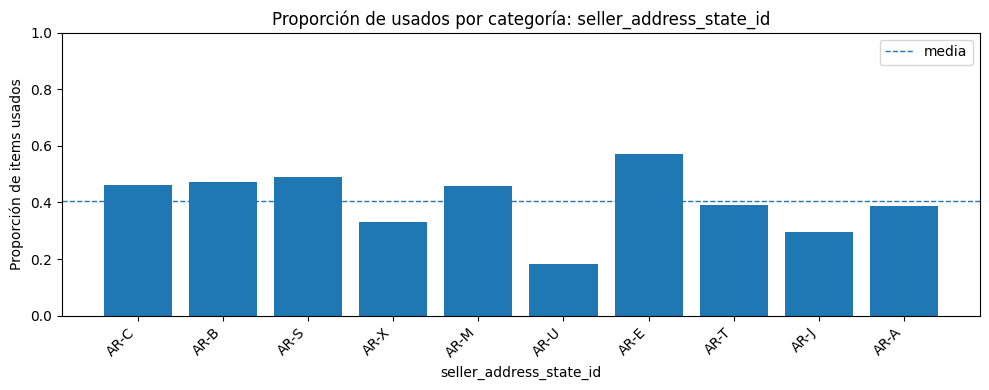

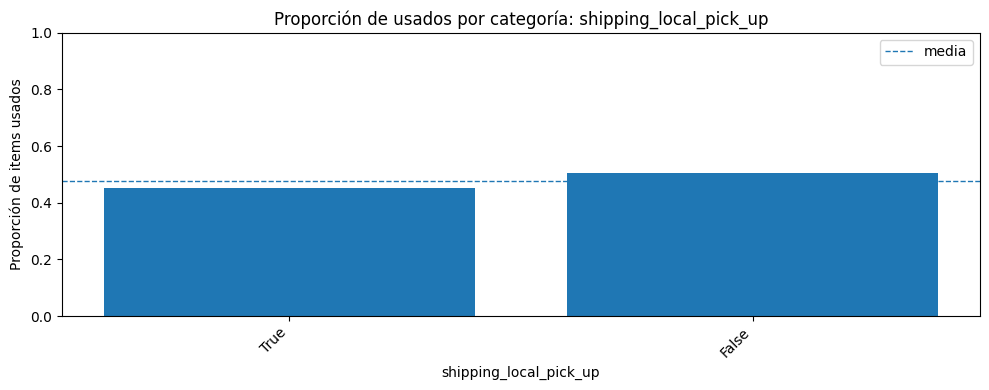

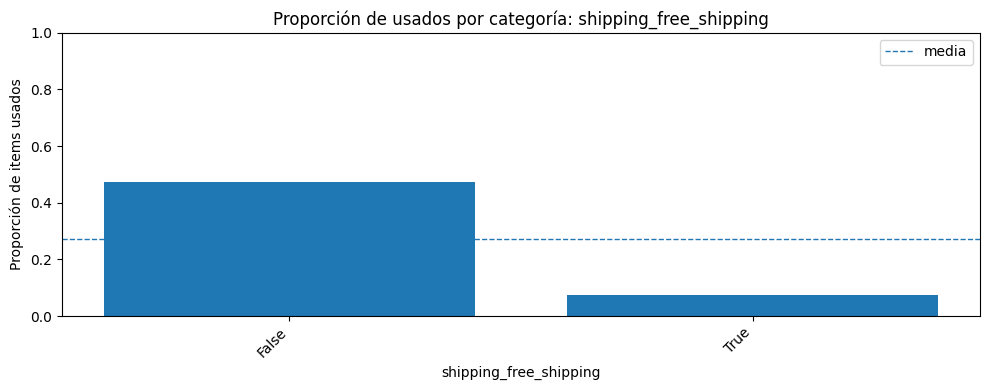

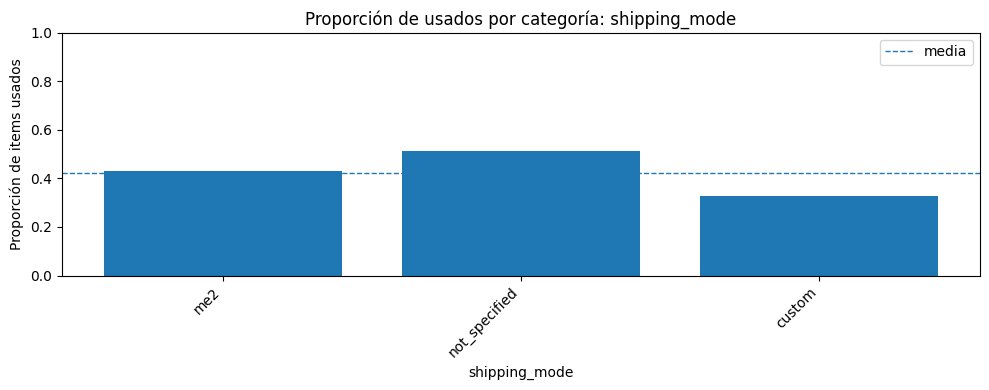

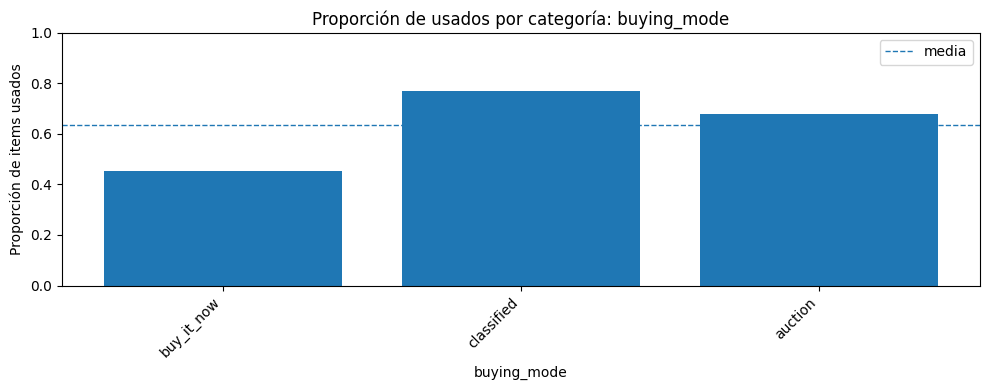

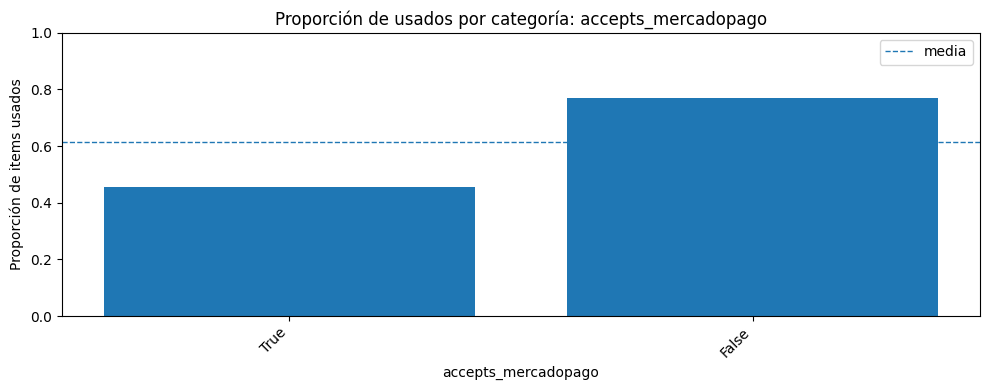

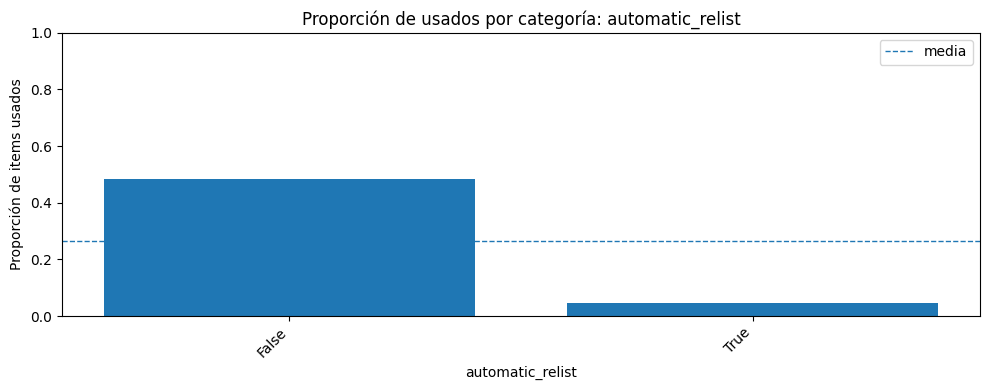

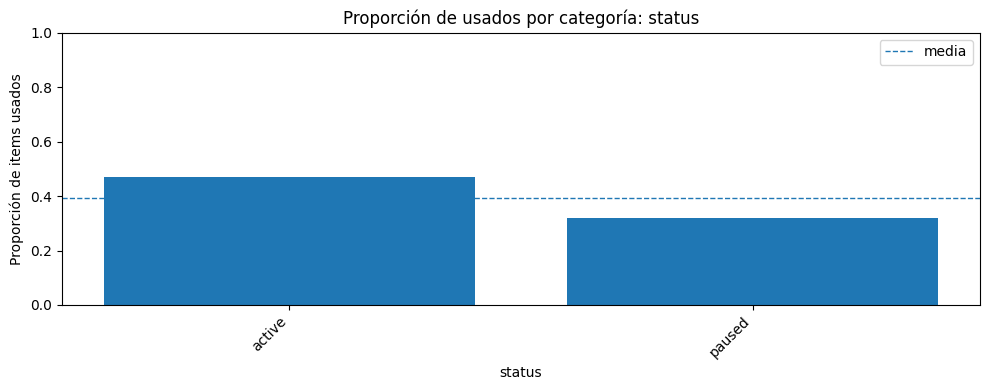

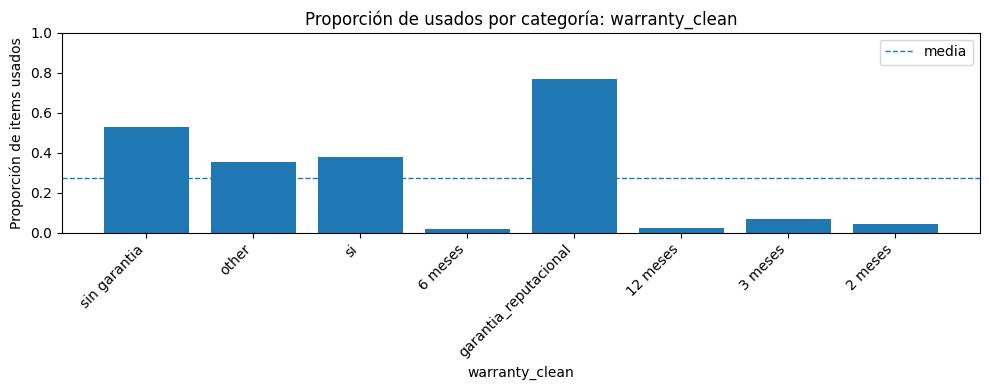

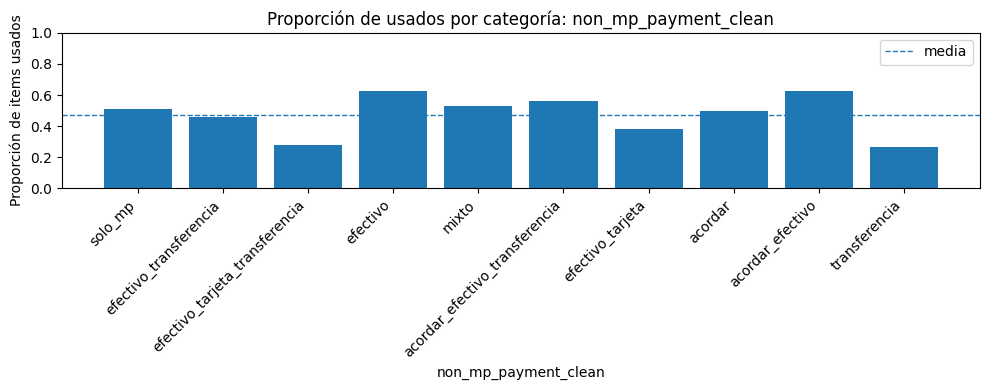

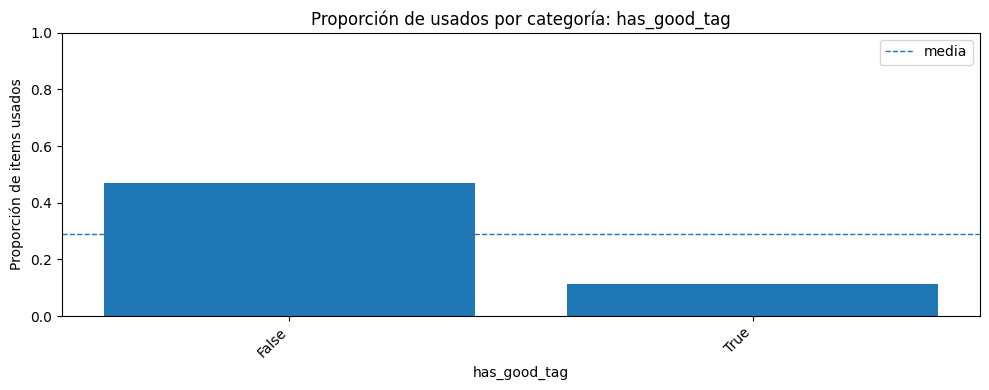

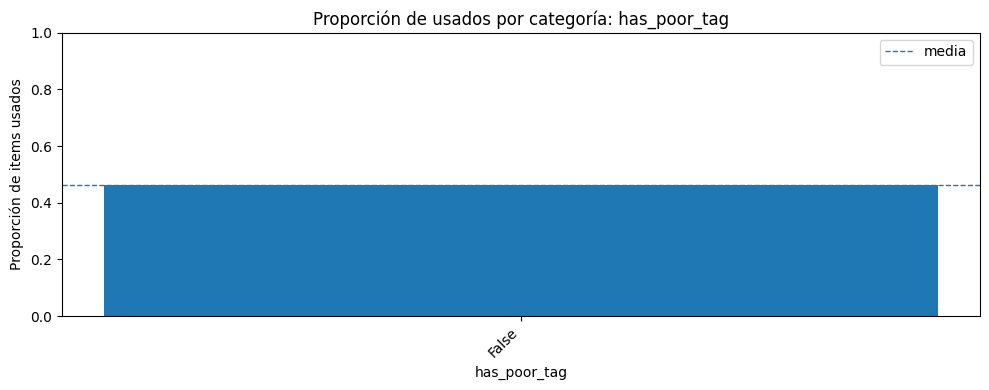

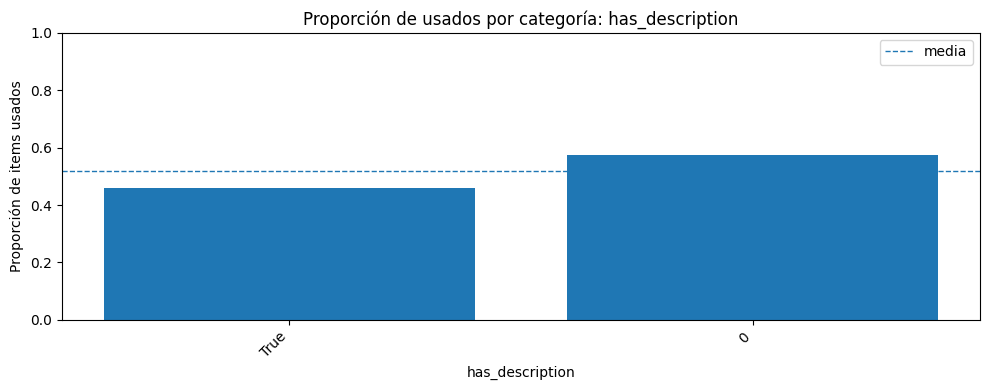

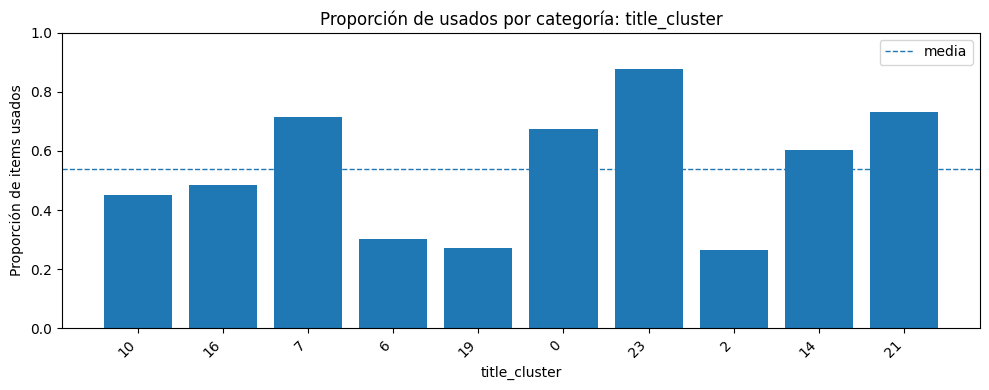

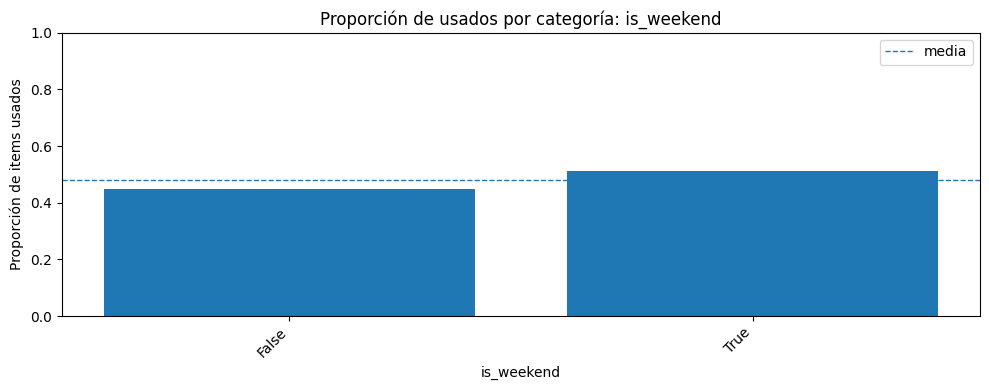

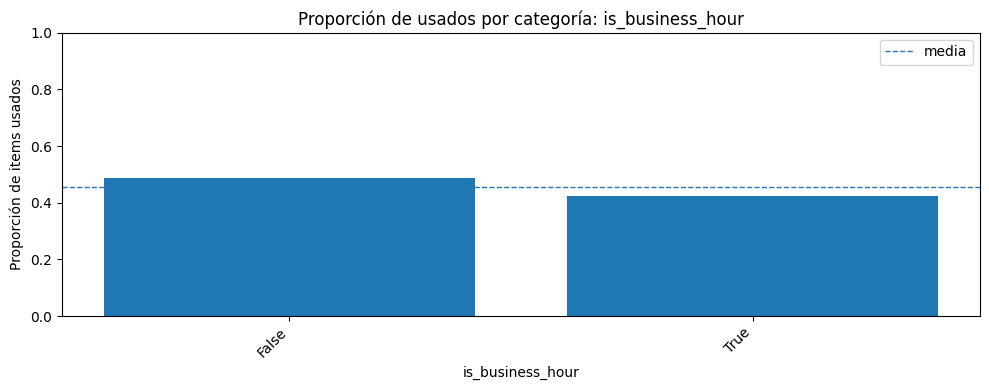

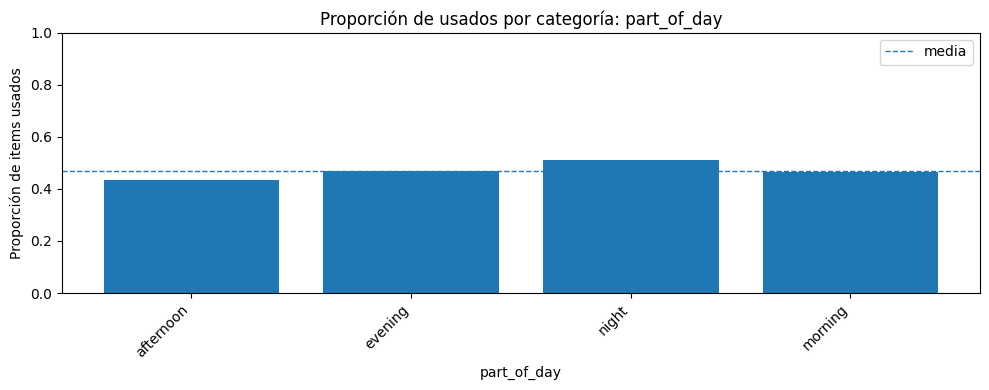

In [335]:
for col in results.keys():
    plot_target_proportions(results, col, top_n=10)

* Se detecta que muchas de las variables categoricas parecen de antemano tener buena señal predictiva. 
* Principalmente warranty_clean, title_cluster, non_mp_payments_clean, automatic_relist, address_state_id, accepts_mp y free_shipping.

#### **Decision sobre encoding**
* Se define en función de la cardinalidad de la variable y de la evidencia empírica de su relación con el target.
* Las variables con muy pocas categorías (hasta 3 clases) se codifican mediante One-Hot Encoding, ya que no generan explosión dimensional y permiten capturar diferencias claras entre clases.
* Para variables de alta cardinalidad, se analizan las proporciones del target por categoría: 
    * cuando se observan diferencias significativas, se utiliza Target Encoding para capturar información predictiva relevante; 
    * en caso contrario, se opta por Frequency Encoding, una alternativa más robusta que evita overfitting y leakage al no depender del target.
* Siempre ser sumamente cuidadoso de no generar data leakage.

### **2.2 Analisis detallado de columnas numericas:**

In [336]:
df_train_clean.select_dtypes(include=["int64", "float64"]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             90000 non-null  float64
 1   initial_quantity  90000 non-null  int64  
 2   sold_quantity     90000 non-null  int64  
 3   listing_type_ord  90000 non-null  int64  
 4   tags_count        90000 non-null  int64  
 5   n_images          90000 non-null  int64  
 6   max_size_pixels   90000 non-null  int64  
 7   target_bin        90000 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 5.5 MB


#### **2.2.1 Generacion de nuevas features derivadas de las numericas**
Se generan variables numéricas derivadas que capturan relaciones relativas y escalas más estables de las variables originales.
En particular, se incluyen métricas de demanda relativa (sell_through_rate, sold_ratio_log), una proxy de calidad visual del aviso (image_density) y transformaciones logarítmicas (log1p) para reducir asimetrías y facilitar el aprendizaje de modelos lineales y no lineales.
Estas transformaciones no introducen leakage, ya que utilizan únicamente información disponible al momento de la publicación del producto

In [342]:
def generate_numeric_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Genera un conjunto acotado de features numéricas derivadas:
    - sell_through_rate
    - sold_ratio_log
    - image_density
    - log1p de price, sold_quantity, initial_quantity, max_size_pixels
    """

    out = pd.DataFrame(index=df.index)

    # ------------------------
    # Log-transformations
    # ------------------------
    out["price_log"] = np.log1p(df["price"])
    out["sold_quantity_log"] = np.log1p(df["sold_quantity"])
    out["initial_quantity_log"] = np.log1p(df["initial_quantity"])
    out["max_size_pixels_log"] = np.log1p(df["max_size_pixels"])

    # ------------------------
    # Demand-related features
    # ------------------------
    out["sell_through_rate"] = (
        df["sold_quantity"] / df["initial_quantity"].replace(0, np.nan)
    )

    out["sold_ratio_log"] = (
        out["sold_quantity_log"] / out["initial_quantity_log"].replace(0, np.nan)
    )

    # ------------------------
    # Image-related feature
    # ------------------------
    out["image_density"] = (
        df["max_size_pixels"] / df["n_images"].replace(0, np.nan)
    )

    return out


In [343]:
# Generar features numéricas derivadas
numeric_features_extra_train = generate_numeric_features(df_train_clean)

# Concatenarlas al dataframe original
df_train_clean = pd.concat(
    [df_train_clean, numeric_features_extra_train],
    axis=1
)

numeric_features_extra_test = generate_numeric_features(df_test_clean)

# Concatenarlas al dataframe original
df_test_clean = pd.concat(
    [df_test_clean, numeric_features_extra_test],
    axis=1
)

In [344]:
#Overview de variables numericas
numeric_cols = df_train_clean.select_dtypes(include=["int64", "float64"]).columns

pd.options.display.float_format = "{:,.2f}".format
df_train_clean[numeric_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
price,"90,000.00","57,813.52","9,089,554.79",0.84,90.00,250.00,800.00,"2,222,222,222.00"
initial_quantity,"90,000.00",34.96,421.09,1.00,1.00,1.00,2.00,"9,999.00"
sold_quantity,"90,000.00",2.33,33.84,0.00,0.00,0.00,0.00,"6,065.00"
listing_type_ord,"90,000.00",2.05,0.90,1.00,2.00,2.00,2.00,7.00
tags_count,"90,000.00",0.77,0.46,0.00,1.00,1.00,1.00,2.00
n_images,"90,000.00",2.93,2.10,0.00,1.00,2.00,4.00,36.00
max_size_pixels,"90,000.00","185,764.76","361,891.95",0.00,0.00,0.00,"160,000.00","1,440,000.00"
target_bin,"90,000.00",0.46,0.50,0.00,0.00,0.00,1.00,1.00
price_log,"90,000.00",5.78,1.75,0.61,4.51,5.53,6.69,21.52
sold_quantity_log,"90,000.00",0.26,0.74,0.00,0.00,0.00,0.00,8.71


In [345]:
#Histogramas de variables numericas
def plot_numeric_histograms(
    df,
    cols,
    bins=50,
    clip_quantile=0.99
):
    """
    Genera histogramas para columnas numéricas (solo escala original).
    """
    for col in cols:
        series = df[col].dropna()

        if series.empty:
            continue

        # Clip para evitar outliers extremos
        upper = series.quantile(clip_quantile)
        series_clip = series[series <= upper]

        plt.figure(figsize=(6, 3))
        plt.hist(series_clip, bins=bins)
        plt.title(f"{col}")
        plt.xlabel(col)
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()


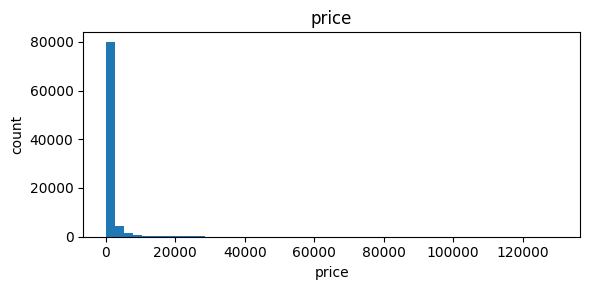

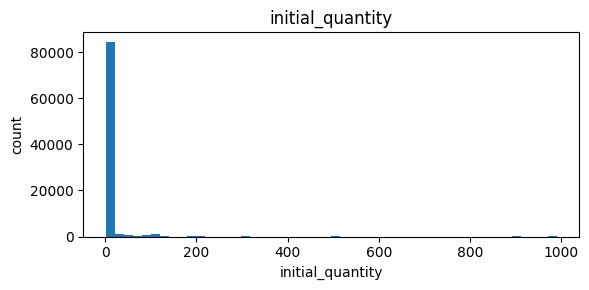

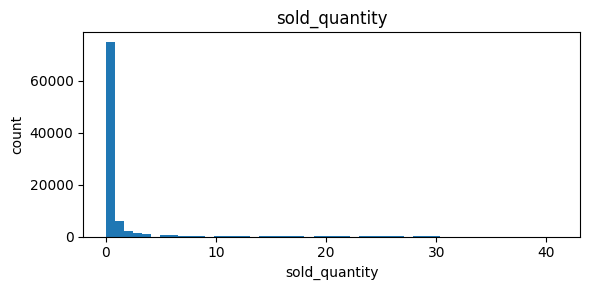

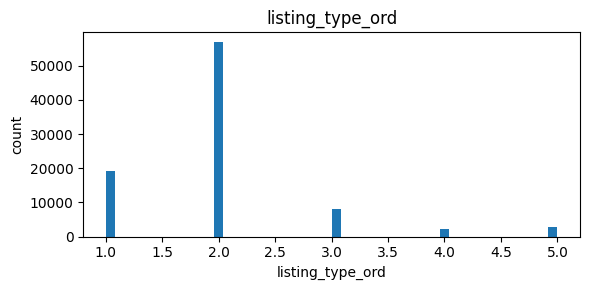

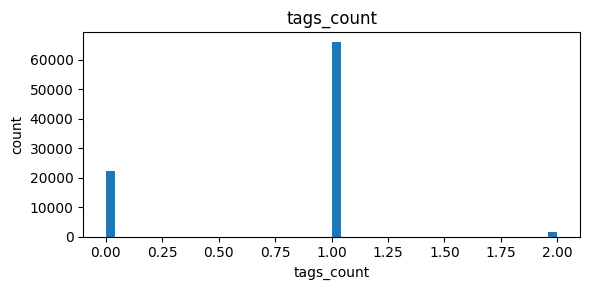

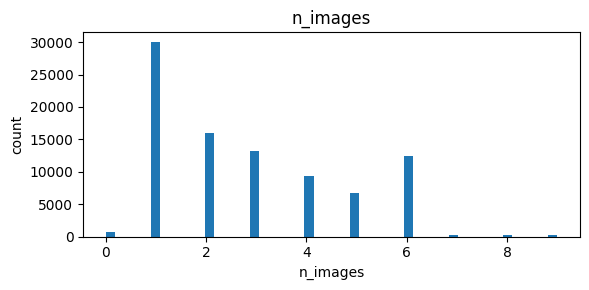

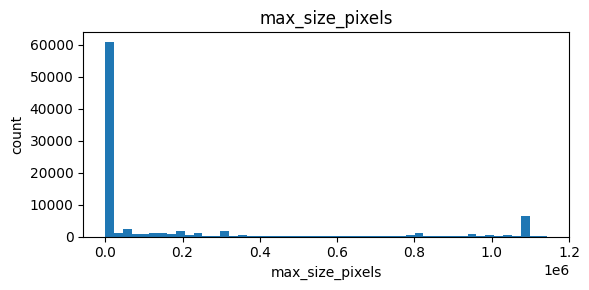

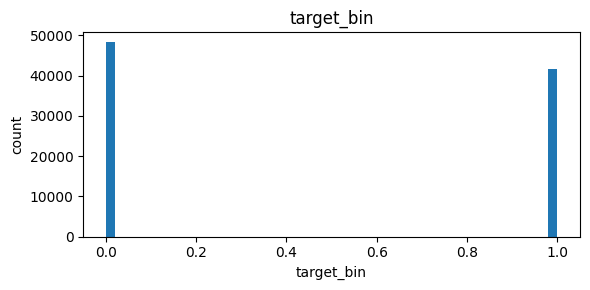

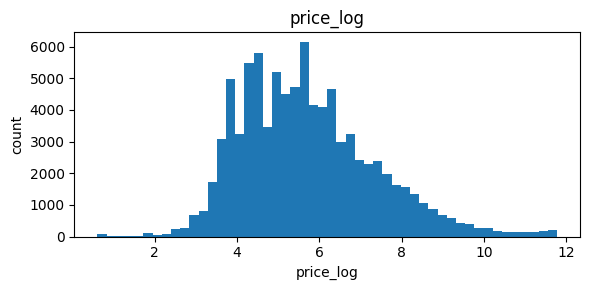

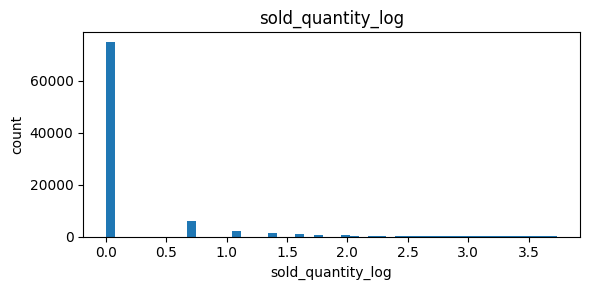

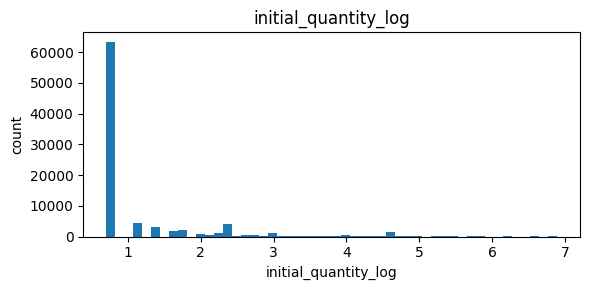

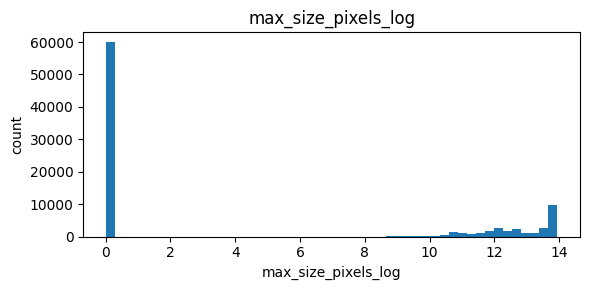

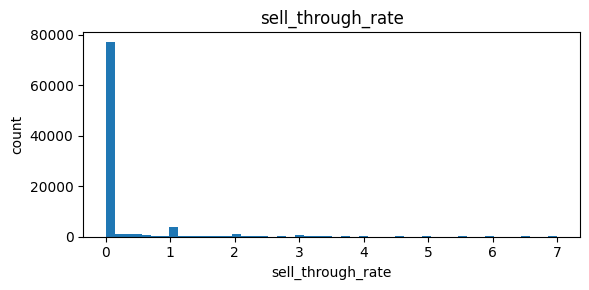

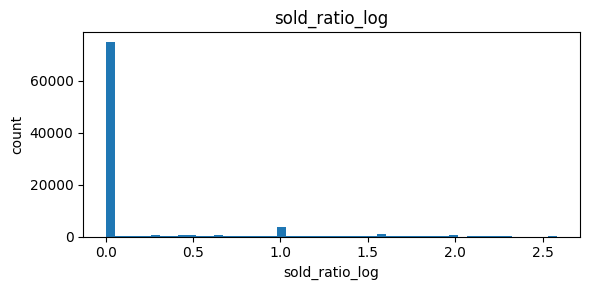

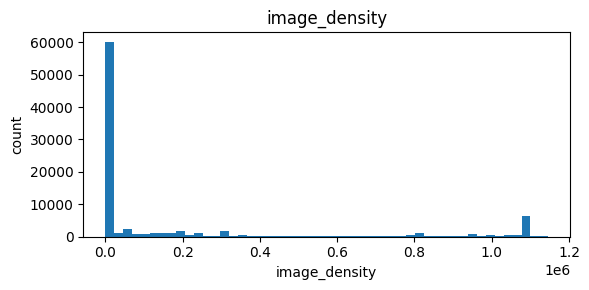

In [346]:
#original y en logaritmo
plot_numeric_histograms(df_train_clean, numeric_cols)

**Observacion:**
* Casi todas las columnas se encuentran fuertemente sesgadas hacia la izquierda (excepto las que son ordinales que fueron generadas a partir de categoricas).
* Aplicando logaritmo se logra centrar la variable de precio y obtener un poco mas de informacion del available_quantity.

**Mirar Correlaciones**

In [347]:
def numeric_target_correlation(
    df: pd.DataFrame,
    numeric_cols: list,
    target_col: str = "target_bin",
    method: str = "pearson"
) -> pd.DataFrame:
    """
    Calcula la correlación entre variables numéricas y un target binario.

    Devuelve un DataFrame ordenado por |correlación|.
    """
    corr = []

    for col in numeric_cols:
        if col == target_col:
            continue

        if col not in df.columns:
            continue

        series = df[[col, target_col]].dropna()
        if series.empty:
            continue

        value = series[col].corr(series[target_col], method=method)

        corr.append({
            "feature": col,
            "correlation": value,
            "abs_correlation": abs(value)
        })

    corr_df = (
        pd.DataFrame(corr)
        .sort_values("abs_correlation", ascending=False)
        .reset_index(drop=True)
    )

    return corr_df

In [352]:
#Corr vs target
numeric_cols = df_train_clean.select_dtypes(include=["number"]).drop(columns='target_bin').columns

corr_df = numeric_target_correlation(
    df_train_clean,
    numeric_cols,
    target_col="target_bin"
)

corr_df


,feature,correlation,abs_correlation
0,initial_quantity_log,-0.40,0.40
1,listing_type_ord,-0.40,0.40
2,sold_quantity_log,-0.29,0.29
3,sold_ratio_log,-0.26,0.26
4,image_density,0.15,0.15
5,max_size_pixels,0.15,0.15
6,sell_through_rate,-0.14,0.14
7,price_log,-0.13,0.13
8,initial_quantity,-0.07,0.07
9,max_size_pixels_log,0.07,0.07


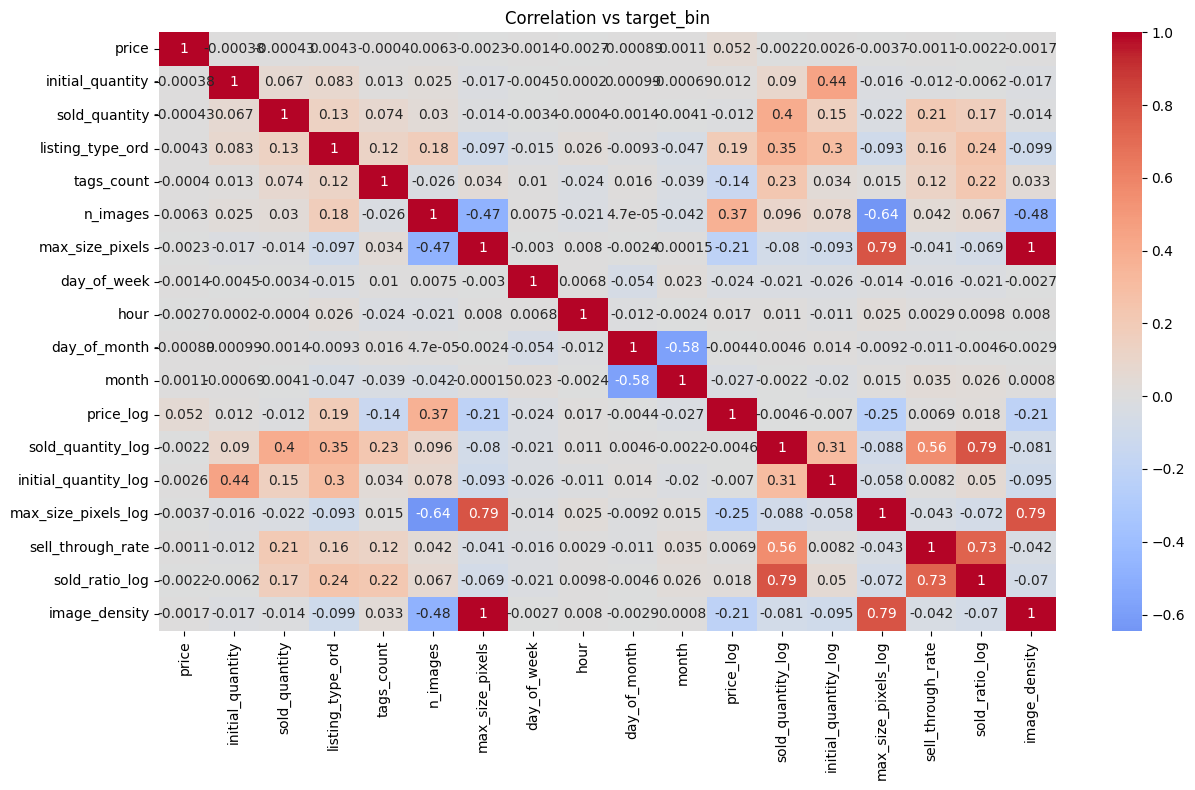

In [359]:
#Matriz de correlaciones
plt.figure(figsize=(13, 8))
sns.heatmap(   
df_train_clean[numeric_cols].corr(),
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation vs target_bin")
plt.tight_layout()
plt.show()

**Observacion:**
* Se observa que algunas variables presentan una correlacion que indica que podrian dar señal predictiva(hay 4 mayores a 0.25 en absoluto).
* Se observa tambien que para el caso de price, sold_quantity, initial_quantity las logs funcionan mucho mejor, con lo cual prescidiremos de las originales.
* Se observan algunas features numericas que correlacionan mucho entre si. Pero como se utilizara un modelo basado en arboles y no son muchas las features en esta situacion considero que no es un problema. Voy a dejarlas a todas y que el modelo seleccione cuales son las mas relevantes.